<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорты" data-toc-modified-id="Импорты-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Заключение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# Переменные

RANDOM_STATE = 42
TEST_SIZE = 0.1

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install sweetviz -q
!pip install phik -q
!pip install optuna-integration[sklearn] -q
!pip install lightgbm -q
!pip install shap -q

## Импорты

In [3]:
import pandas as pd
import sweetviz as sv
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import resources, phik_matrix
import shap
import sklearn
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder, 
                                   MinMaxScaler,
                                   RobustScaler)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
import lightgbm as lgb

## Подготовка

In [4]:
df_base=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df_base.sort_index(inplace=True)
df_base.sample(10)

,num_orders
datetime,
2018-06-13 20:50:00,20
2018-04-17 05:10:00,1
2018-07-30 23:40:00,17
2018-05-17 07:00:00,1
2018-06-30 14:50:00,12
2018-03-20 10:50:00,7
2018-06-16 14:00:00,10
2018-04-30 17:00:00,10
2018-06-03 09:20:00,3


**Таблицу открыл и сразу сделал столбец даты индексом + отсортировал по возрастанию**

In [5]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Пропусков нет**

In [6]:
df_base = df_base.resample('1h').sum()
df_base.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Согласно ТЗ сделал ресэмплирование по часу.**

In [7]:
# Cоздаем функцию для добавления новых фич
def new_features(df, max_lag, rolling_mean_size):
    data=df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['week_day'] = data.index.weekday
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    #Взял скользящую статистику вместо константных значений отклонения, чтобы избежать очевидной линейной зависимости
    data['rolling_std'] = data['num_orders'].rolling(rolling_mean_size).std() 
    data['std_shift_residuals'] = data['num_orders'].shift(max_lag) - data['rolling_std']
    data['mean_shift_residuals'] = data['num_orders'].shift(max_lag) - data['rolling_mean']
    
    r=1
    for i in range(1, max_lag+1):
        k='lag_'+str(r)
        data[k] = data['num_orders'].shift(i)
        r+=1
    data['rolling_mean'] = data['num_orders'].shift(fill_value=0).rolling(rolling_mean_size).mean()
    return data

# Решил таким способ создать фичу времен года
def get_season(month):
    if month in [1,2,12]:
        return 'winter'
    elif month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    else:
        return 'autumn'
    
data = new_features(df_base,5,24)
data['season'] = data['month'].apply(get_season)

data.head(10)

,num_orders,year,month,day,hour,week_day,rolling_mean,rolling_std,std_shift_residuals,mean_shift_residuals,lag_1,lag_2,lag_3,lag_4,lag_5,season
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring
2018-03-01 01:00:00,85,2018,3,1,1,3,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN,spring
2018-03-01 02:00:00,71,2018,3,1,2,3,NaN,NaN,NaN,NaN,85.0,124.0,NaN,NaN,NaN,spring
2018-03-01 03:00:00,66,2018,3,1,3,3,NaN,NaN,NaN,NaN,71.0,85.0,124.0,NaN,NaN,spring
2018-03-01 04:00:00,43,2018,3,1,4,3,NaN,NaN,NaN,NaN,66.0,71.0,85.0,124.0,NaN,spring
2018-03-01 05:00:00,6,2018,3,1,5,3,NaN,NaN,NaN,NaN,43.0,66.0,71.0,85.0,124.0,spring
2018-03-01 06:00:00,12,2018,3,1,6,3,NaN,NaN,NaN,NaN,6.0,43.0,66.0,71.0,85.0,spring
2018-03-01 07:00:00,15,2018,3,1,7,3,NaN,NaN,NaN,NaN,12.0,6.0,43.0,66.0,71.0,spring
2018-03-01 08:00:00,34,2018,3,1,8,3,NaN,NaN,NaN,NaN,15.0,12.0,6.0,43.0,66.0,spring


**Создаем новые признаки в таблицу.**

## Анализ

                                             |          | [  0%]   00:00 -> (? left)


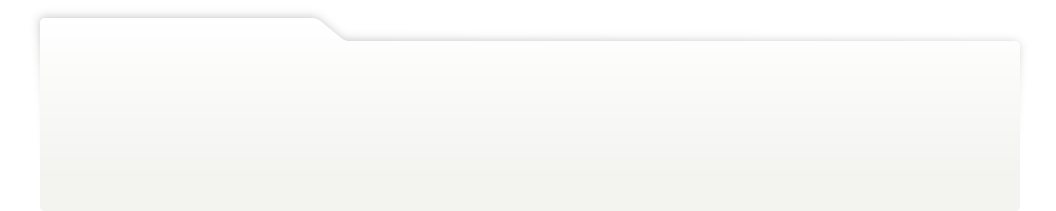
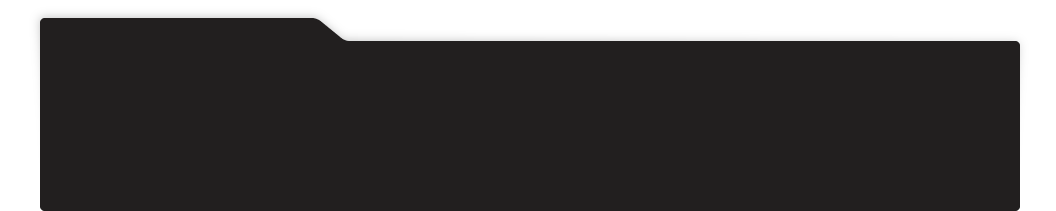
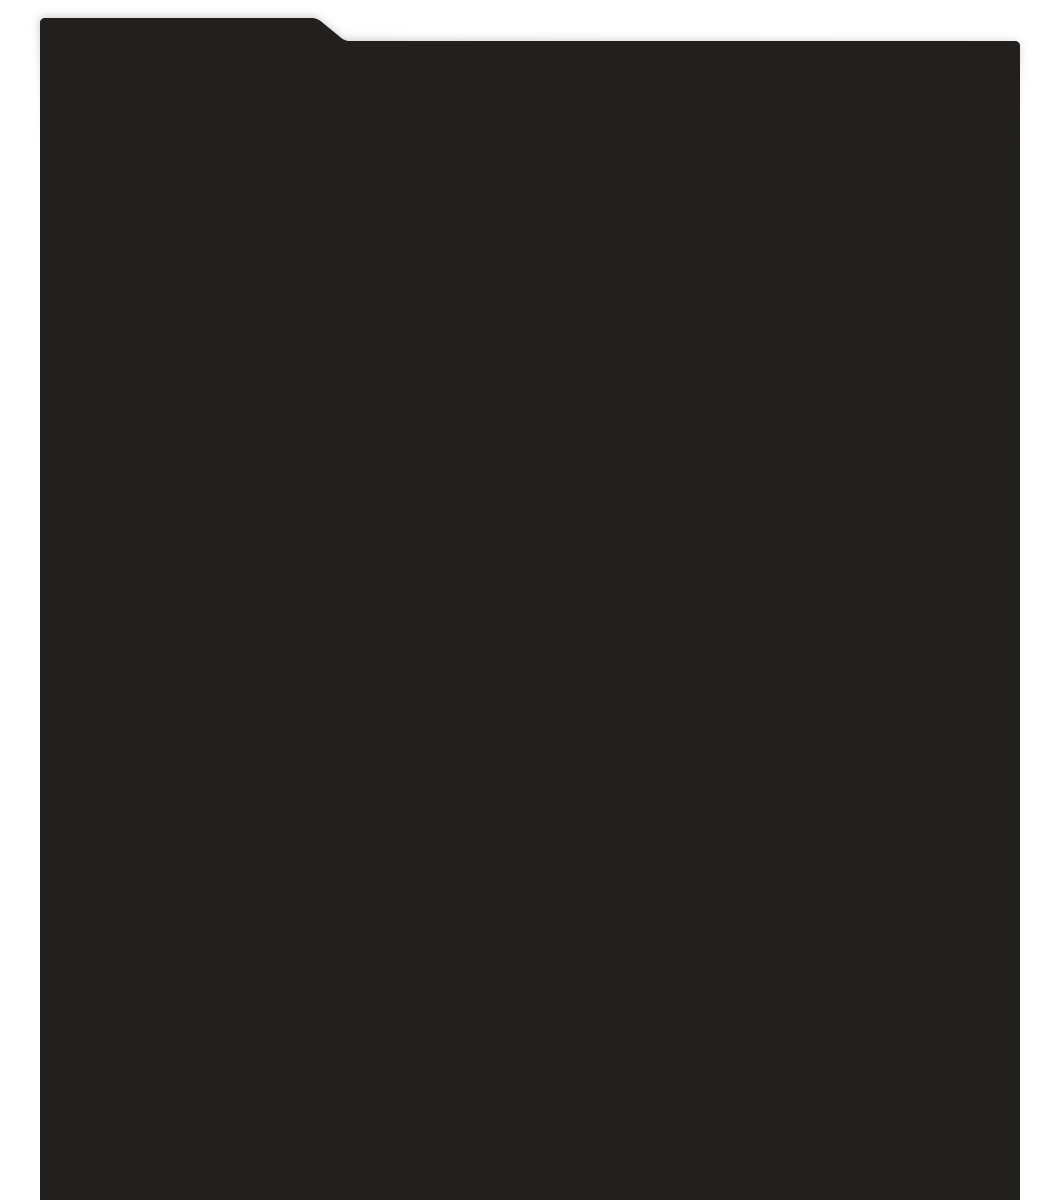
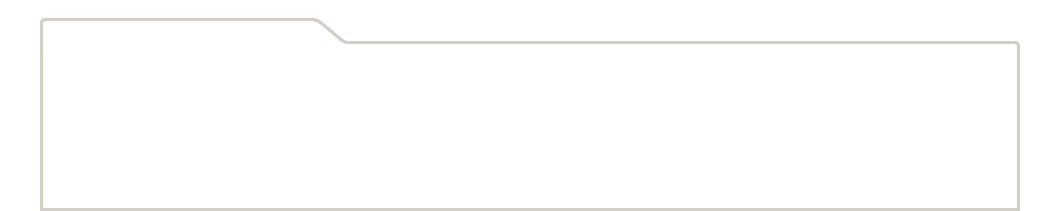
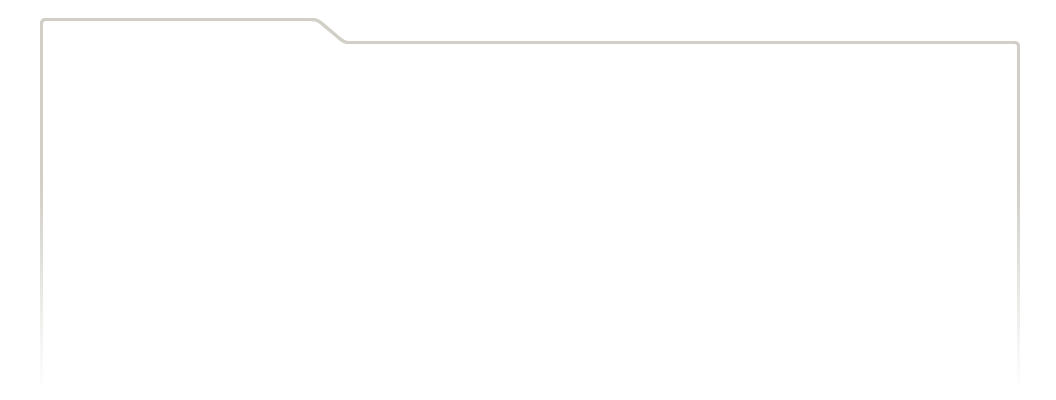
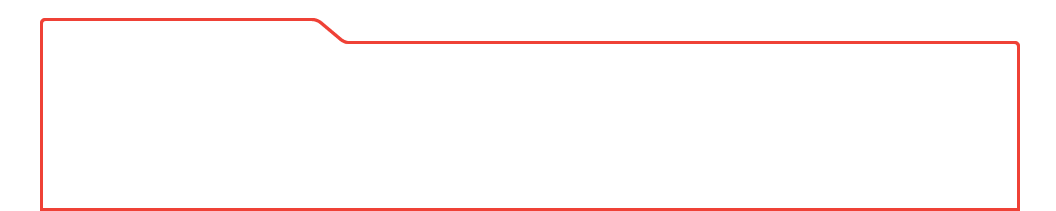
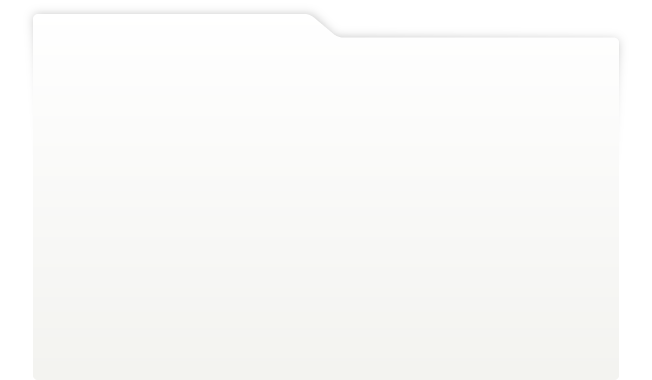
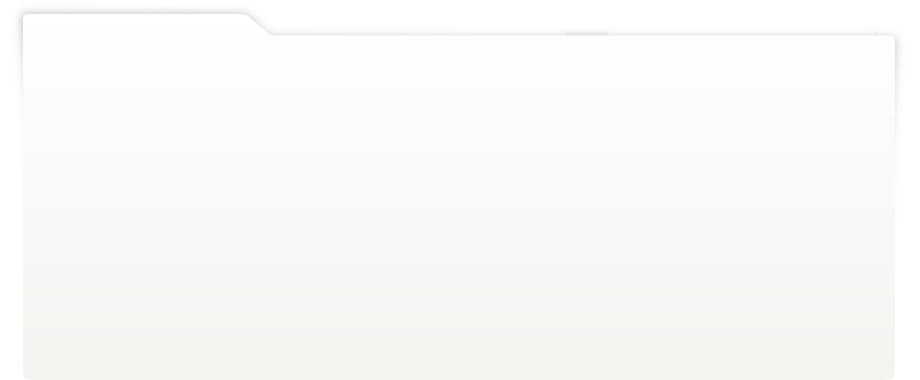
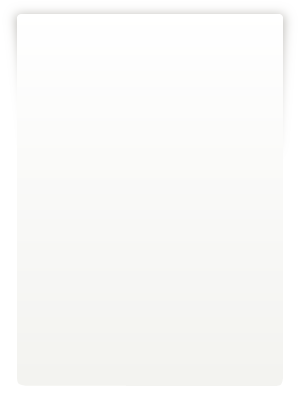
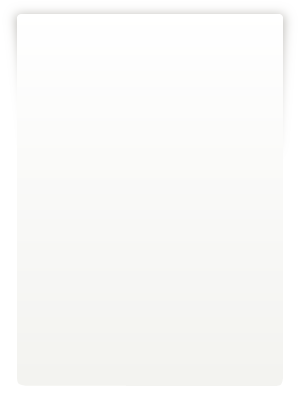
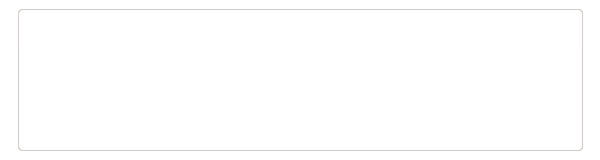
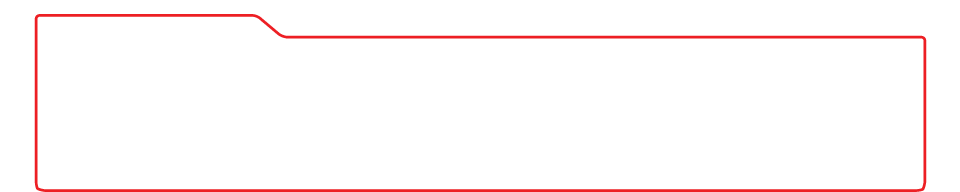
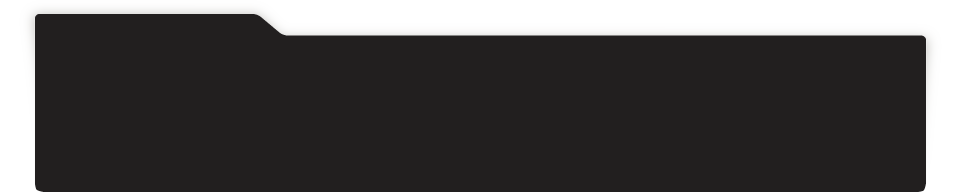
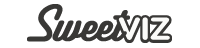
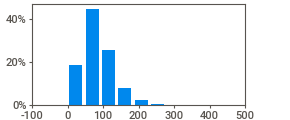
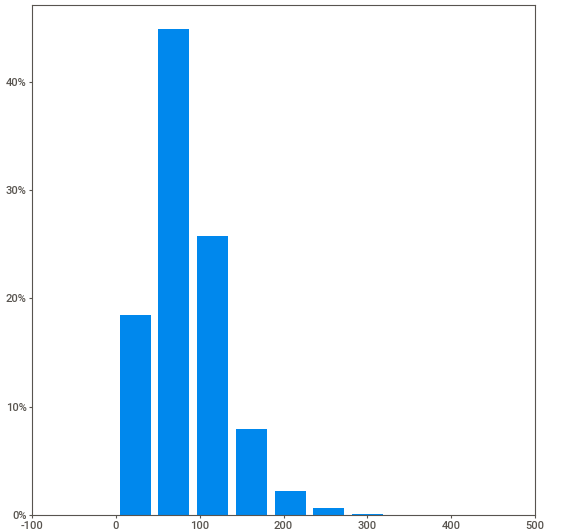
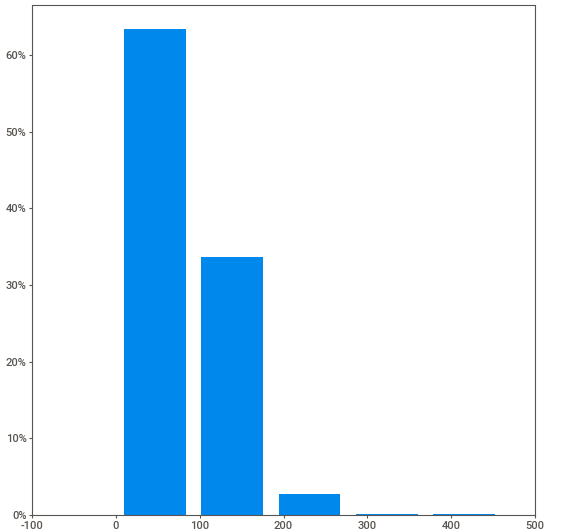
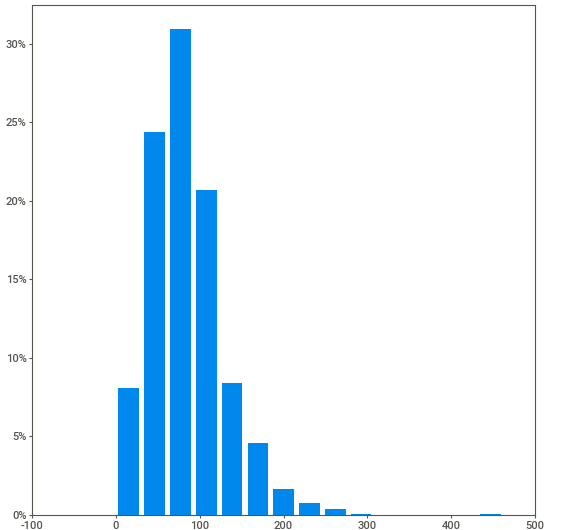
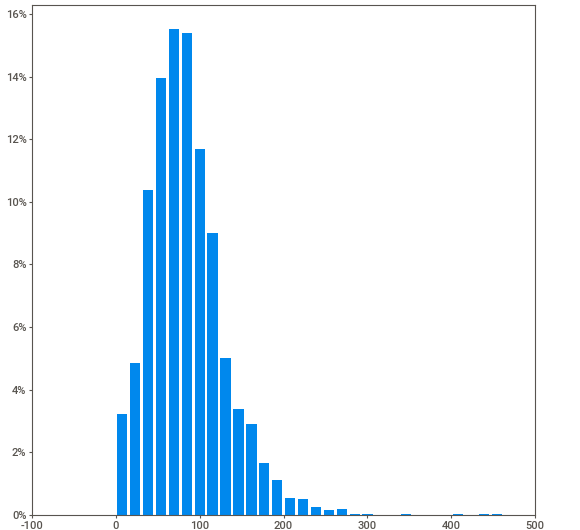
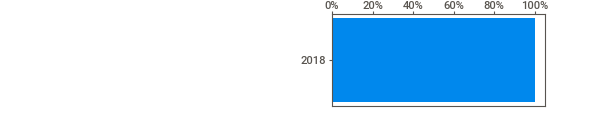
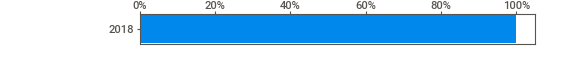
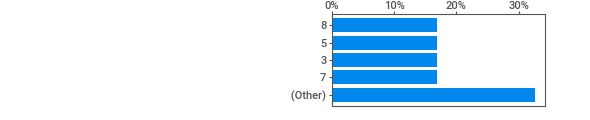
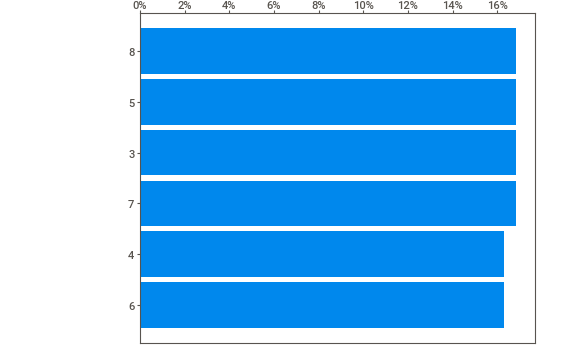
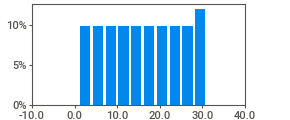
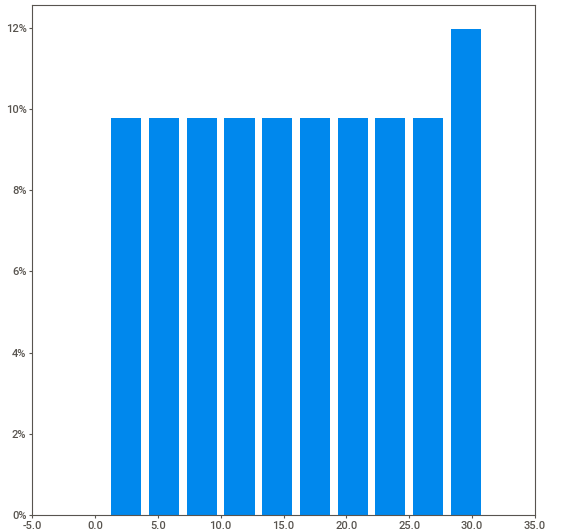
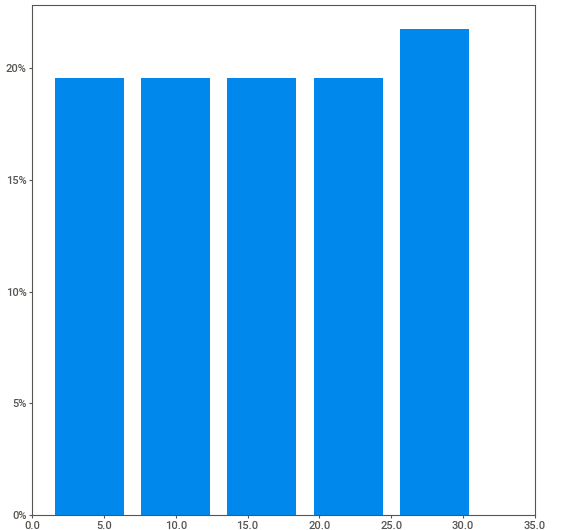
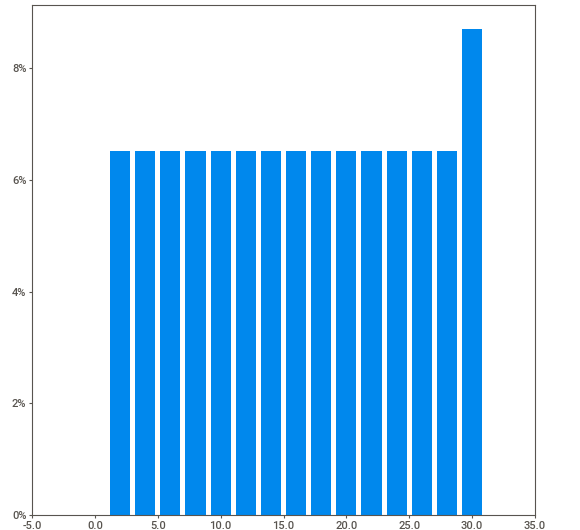
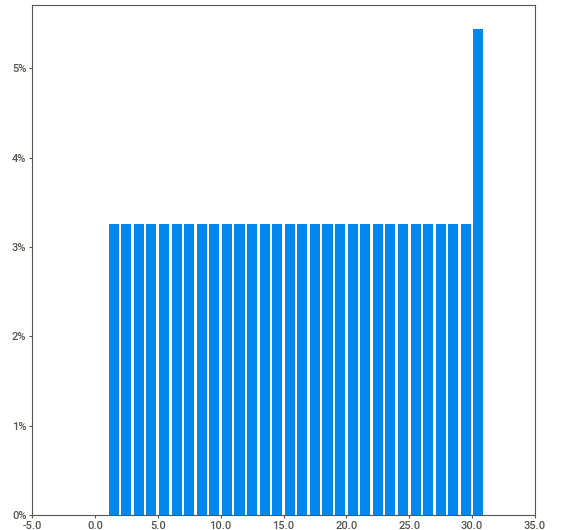
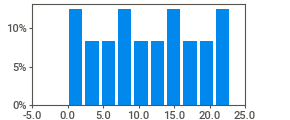
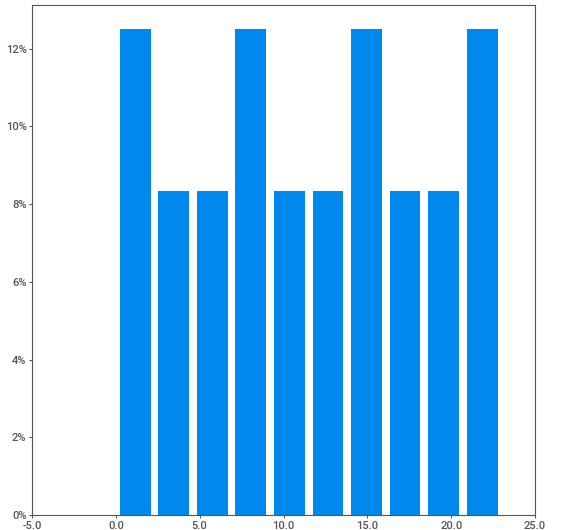
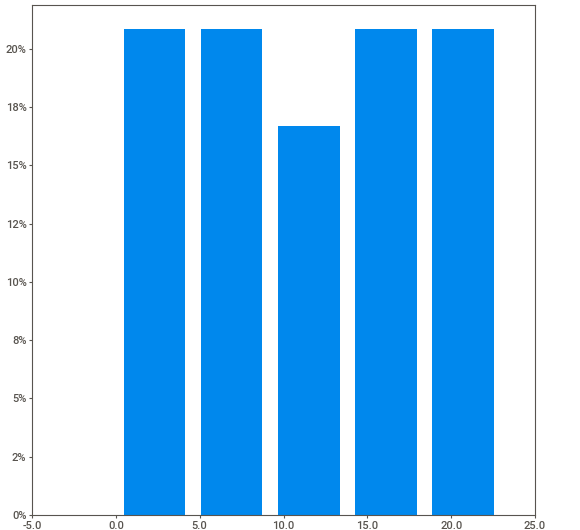
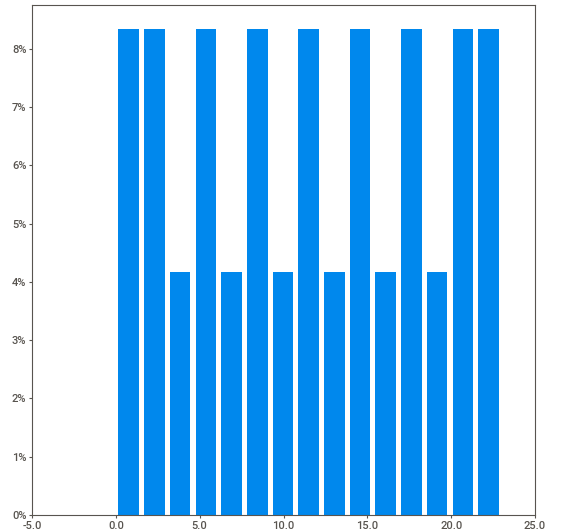
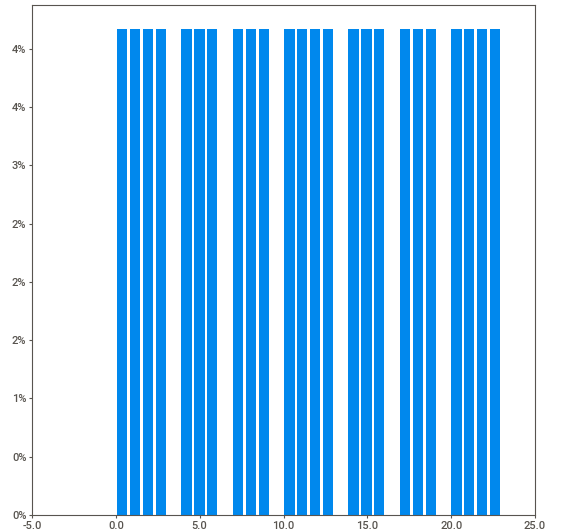
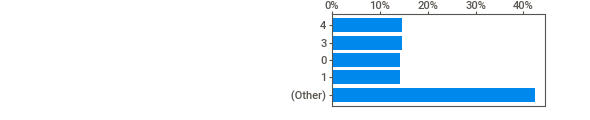
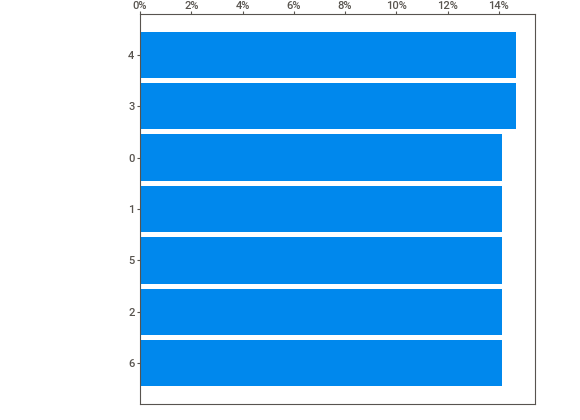
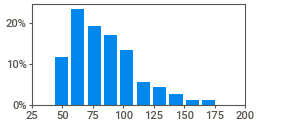
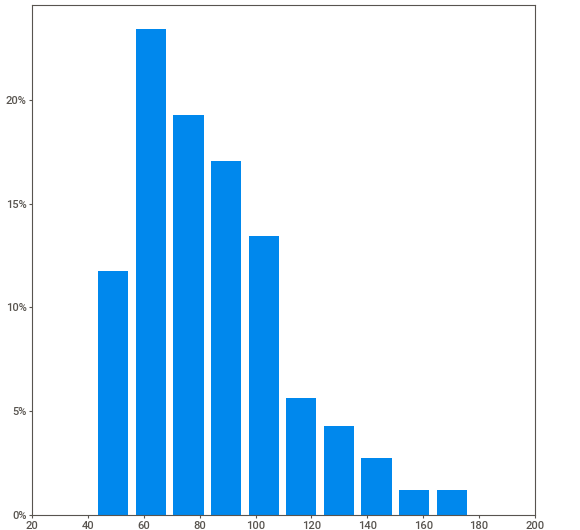
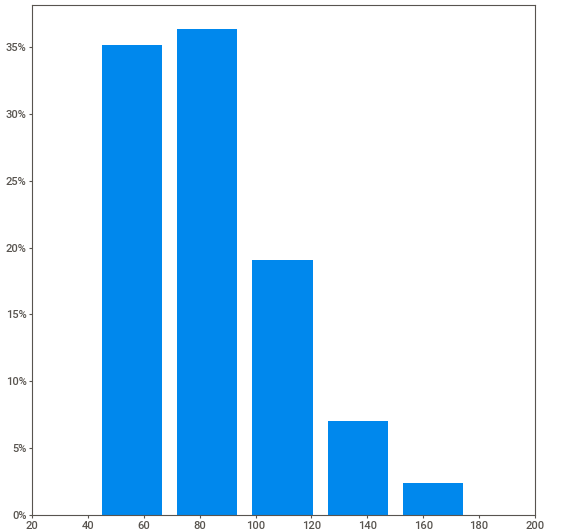
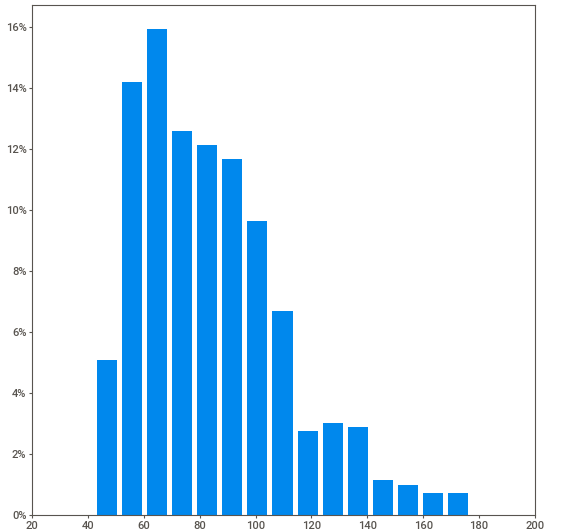
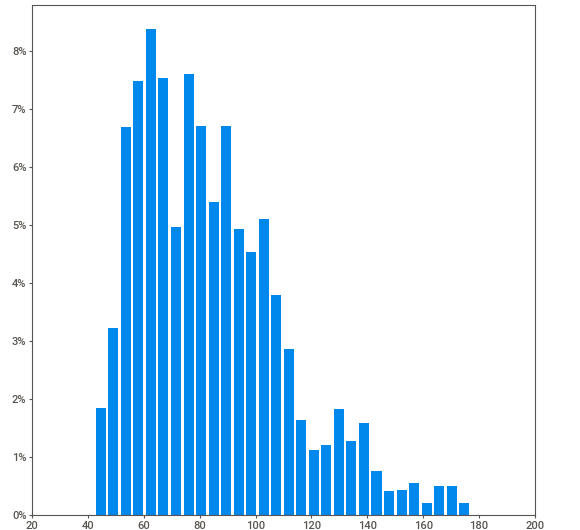
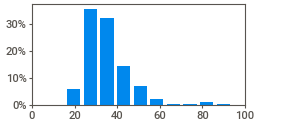
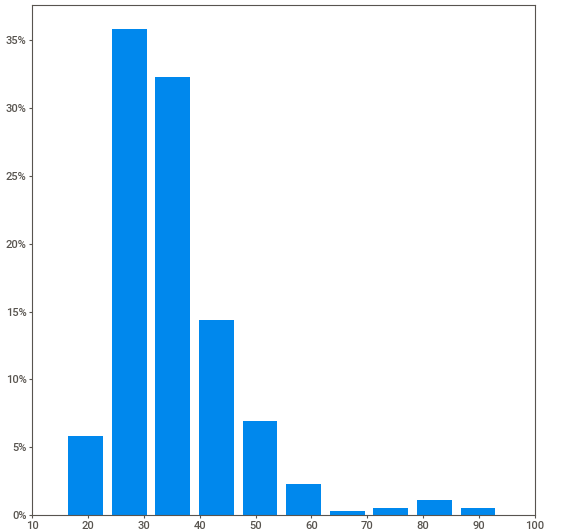
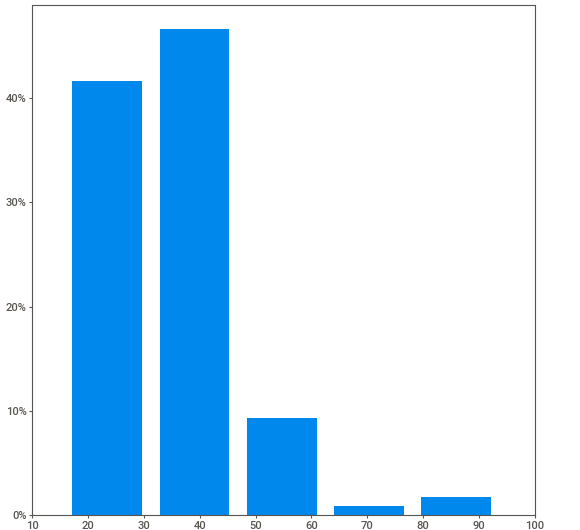
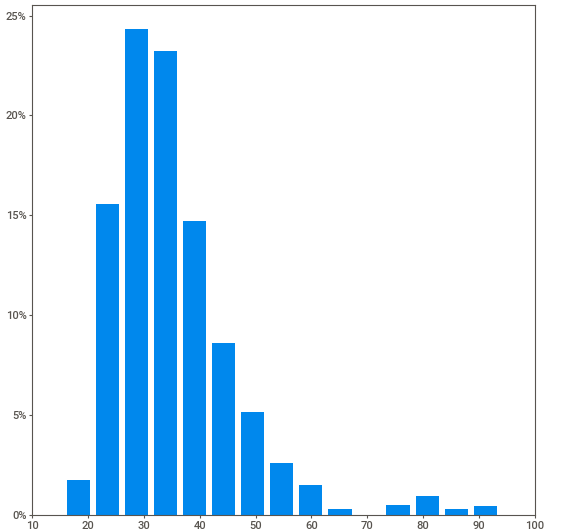
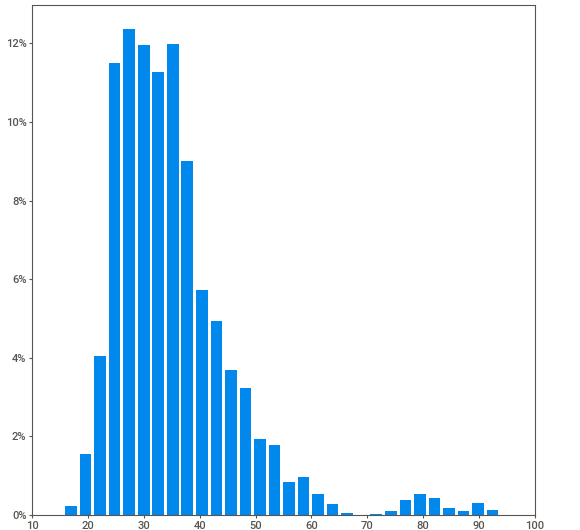
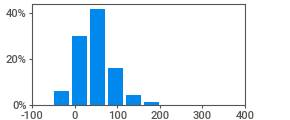
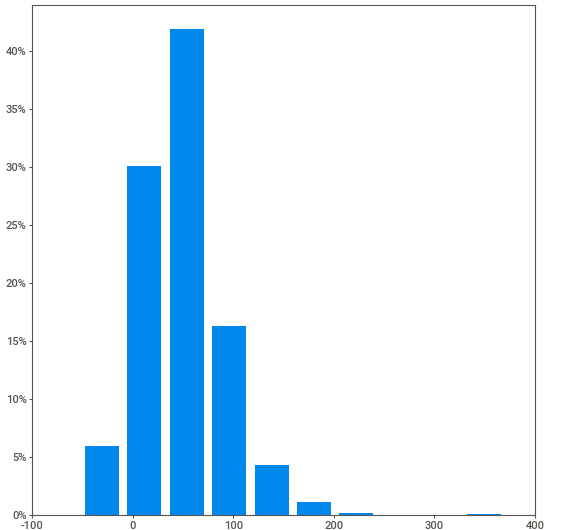
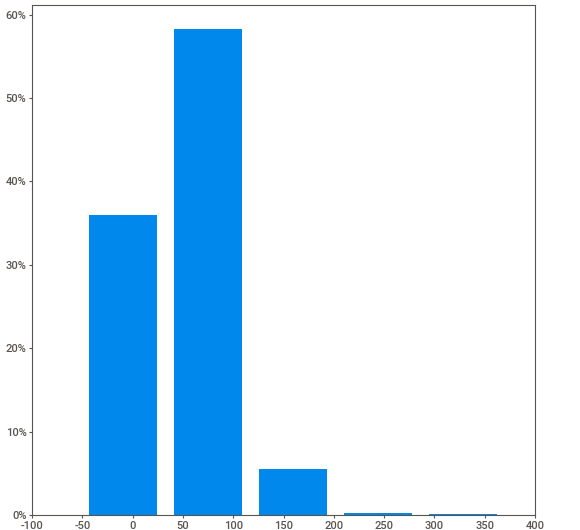
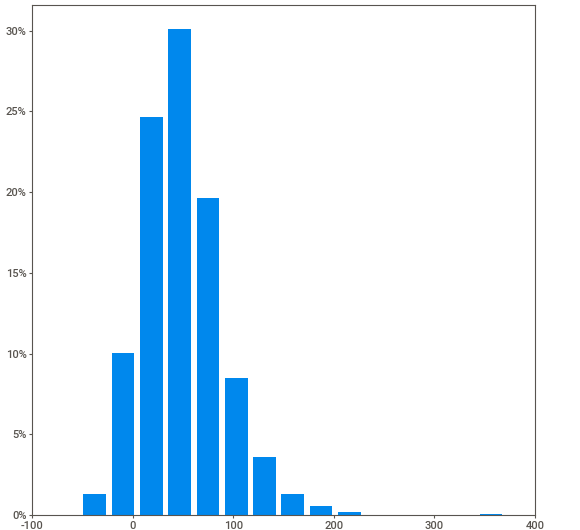
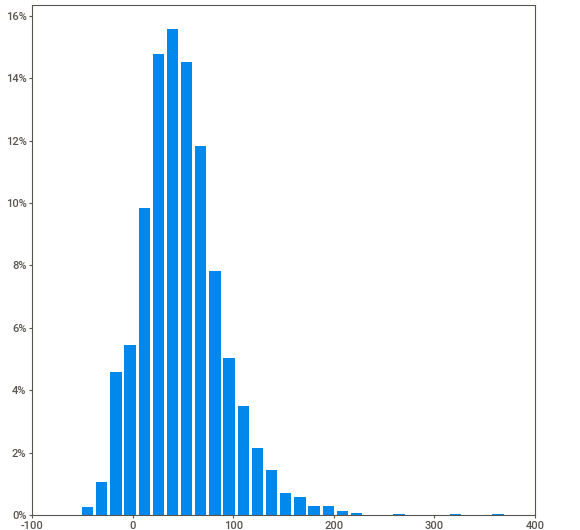
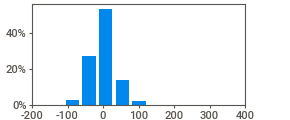
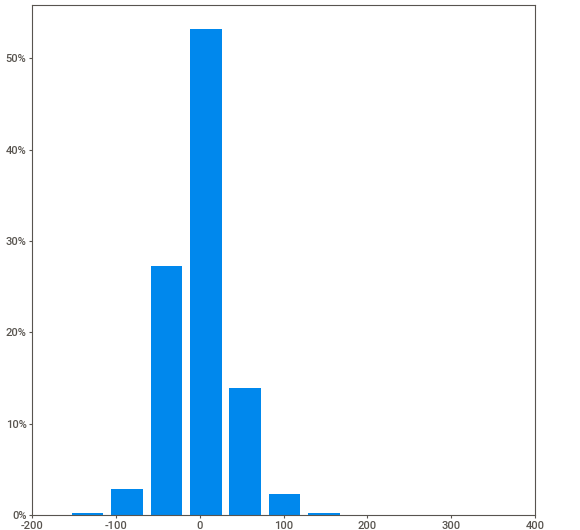
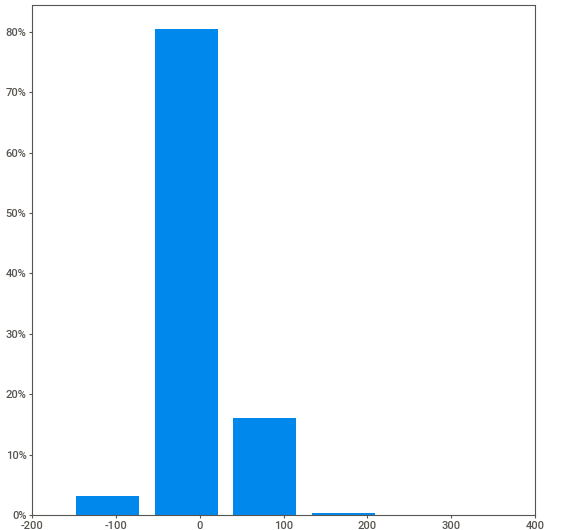
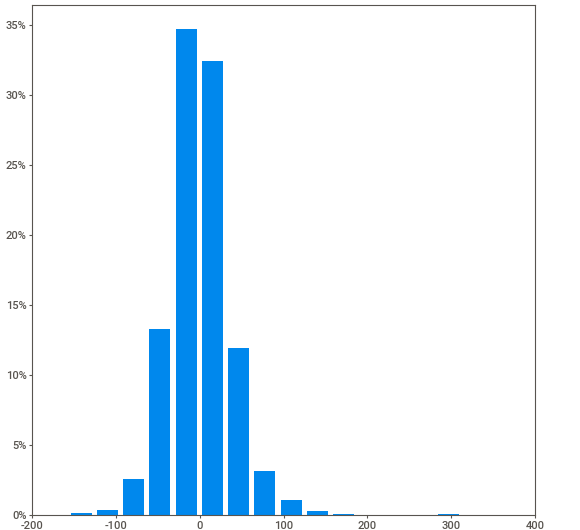
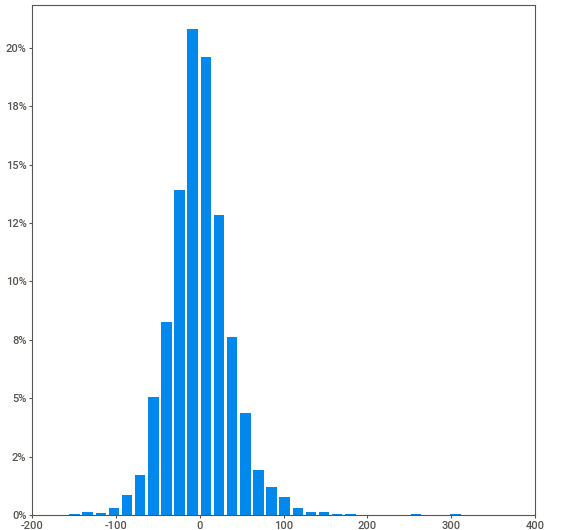
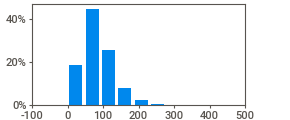
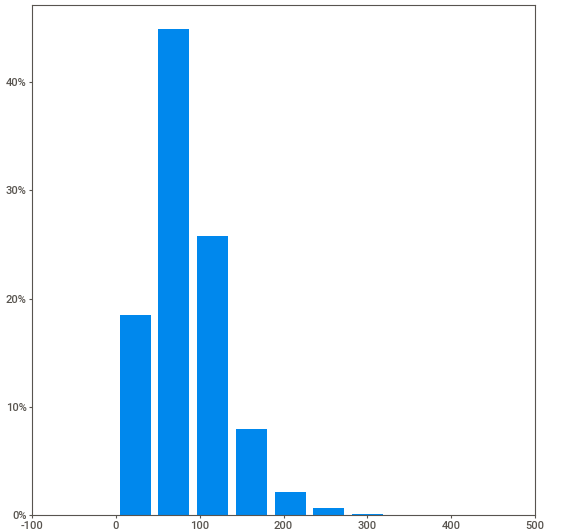
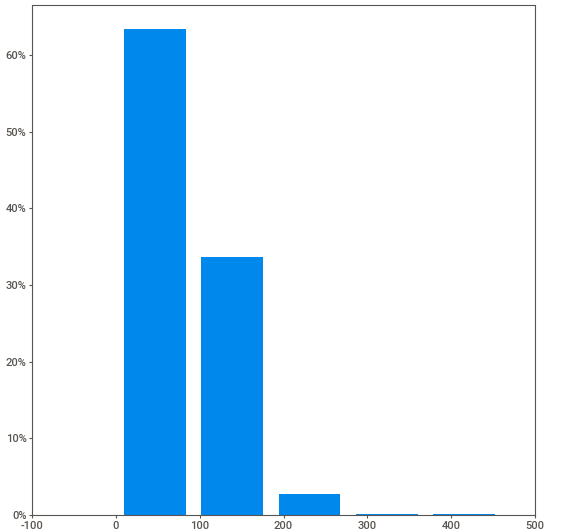
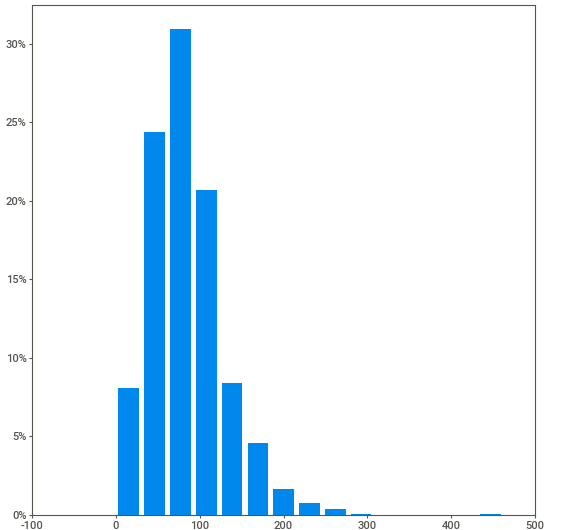
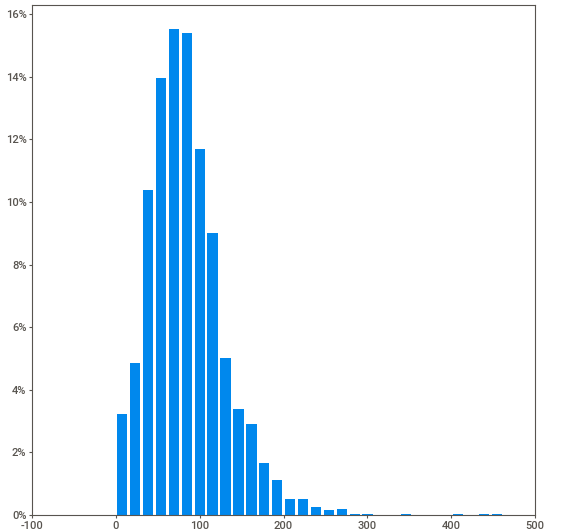
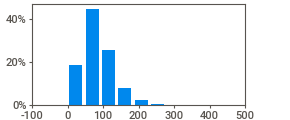
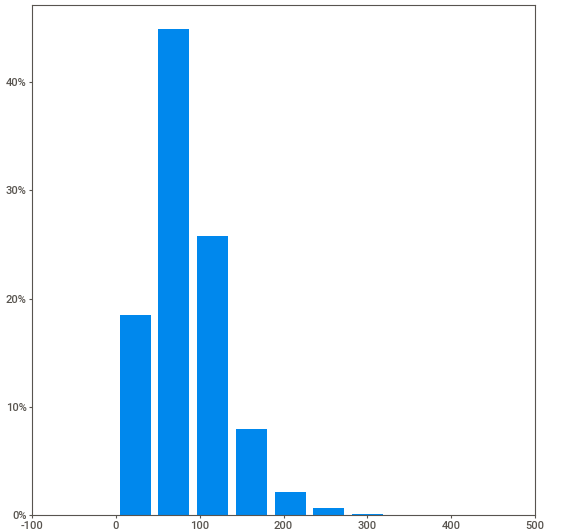
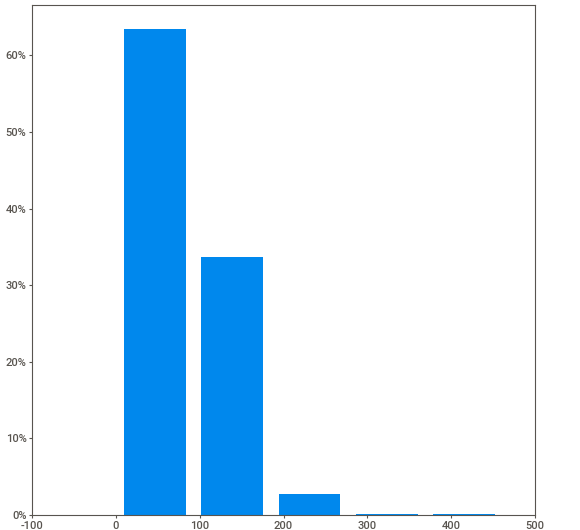
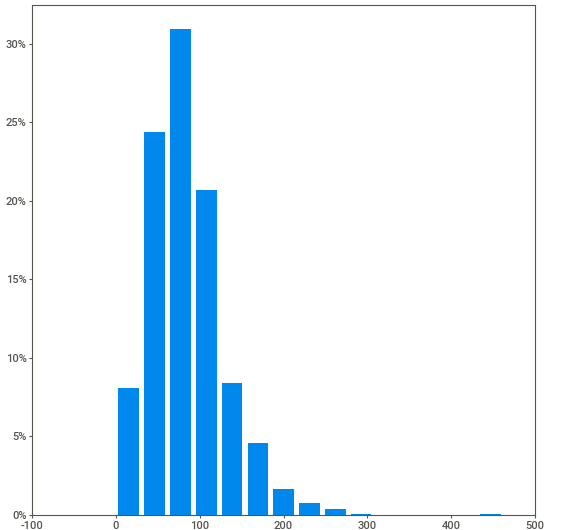
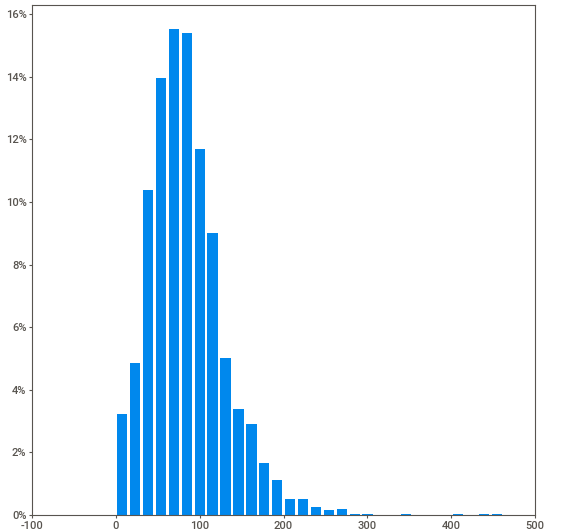
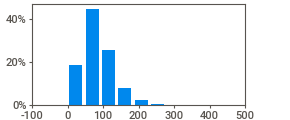
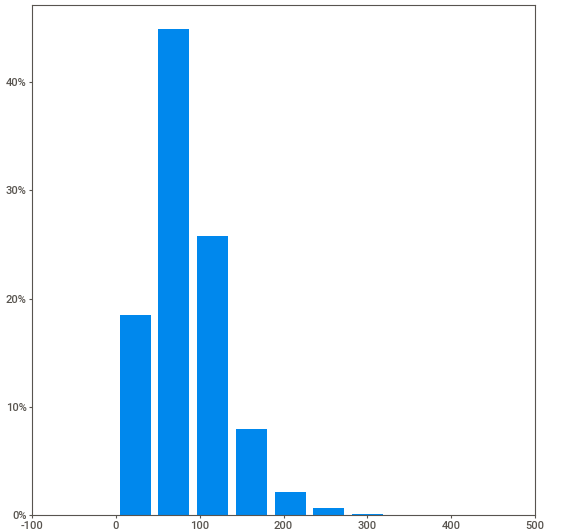
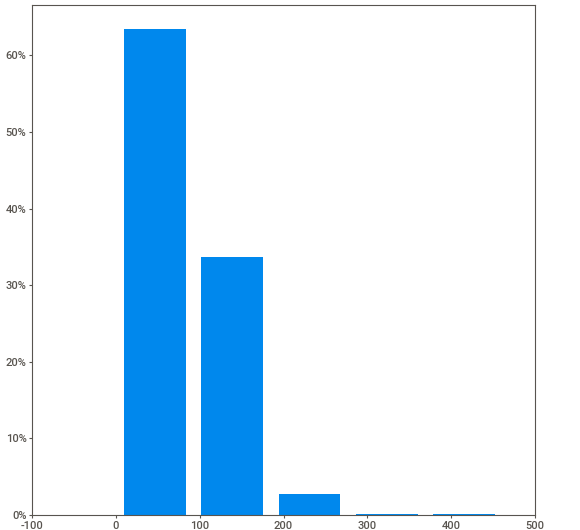
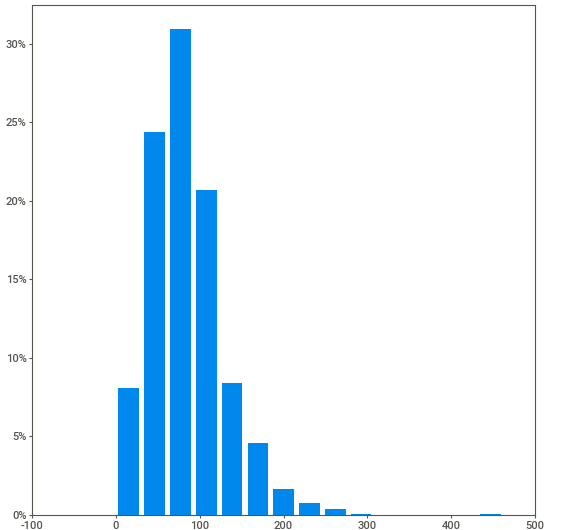
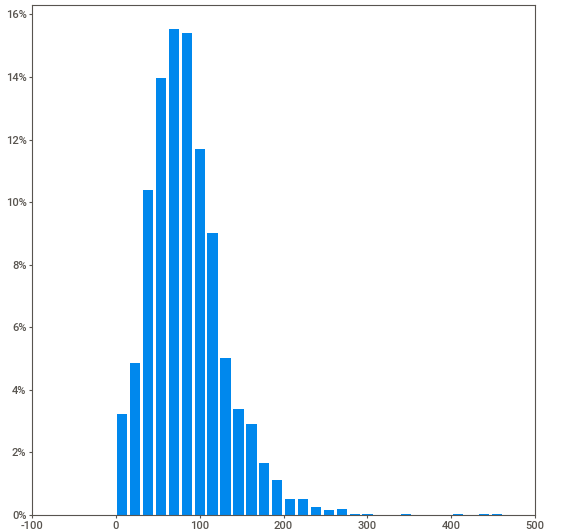
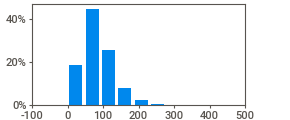
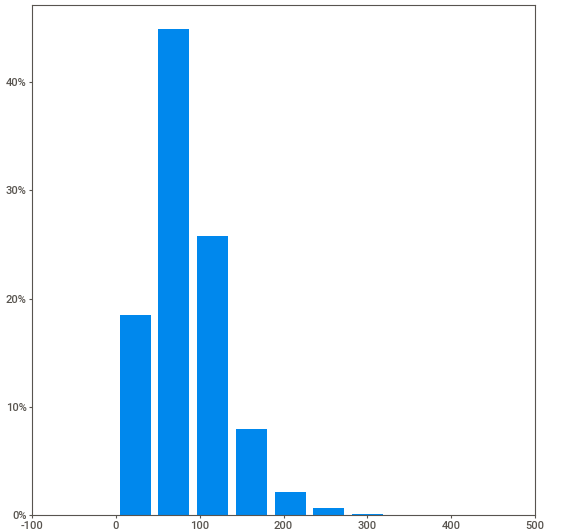
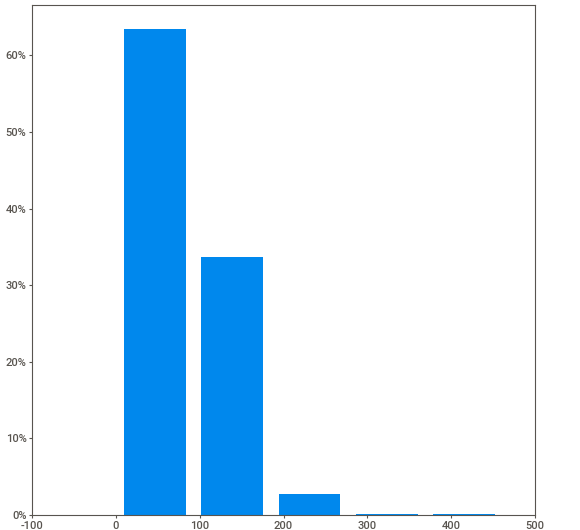
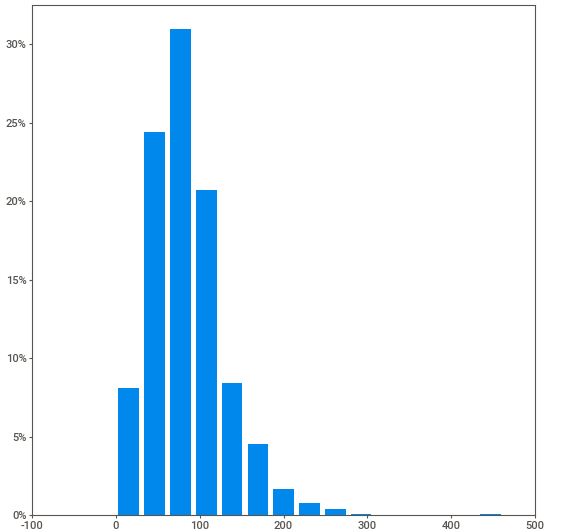
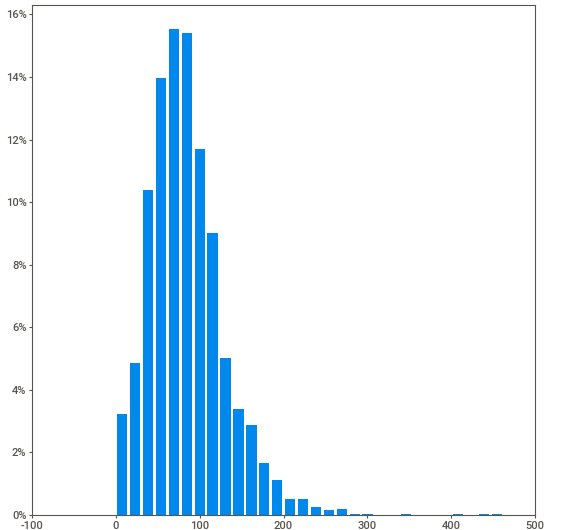
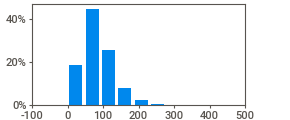
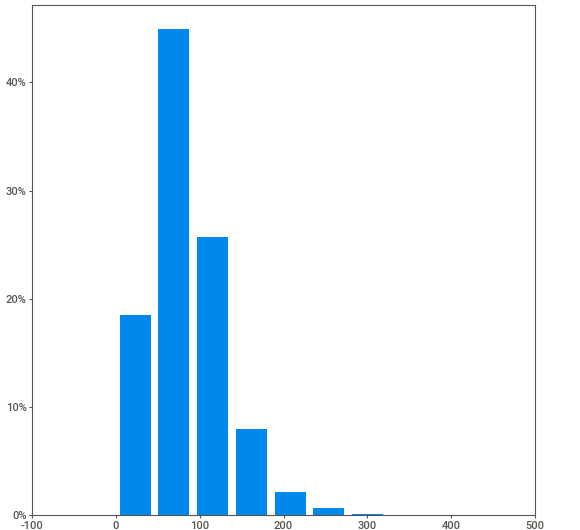
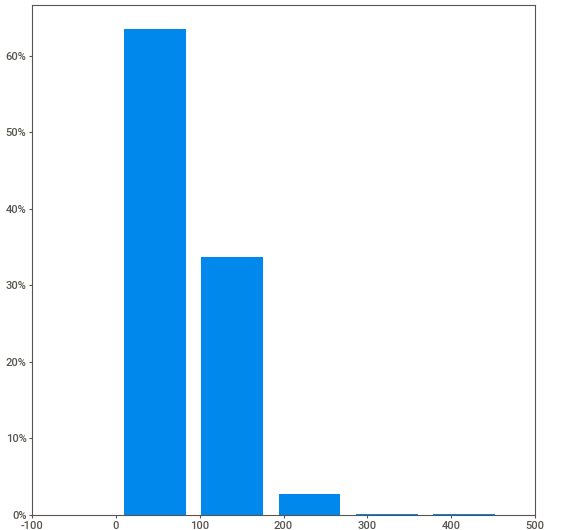
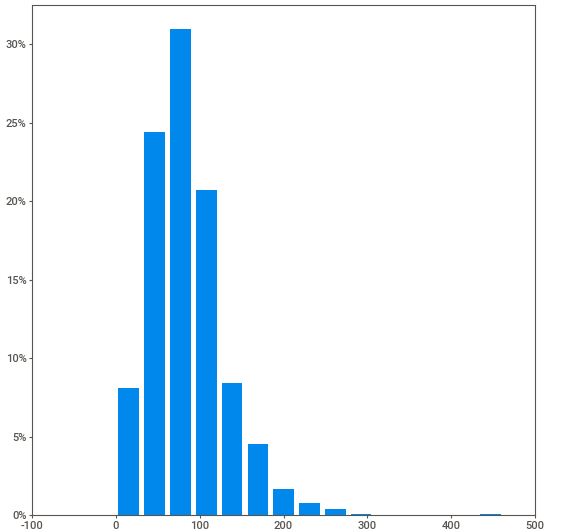
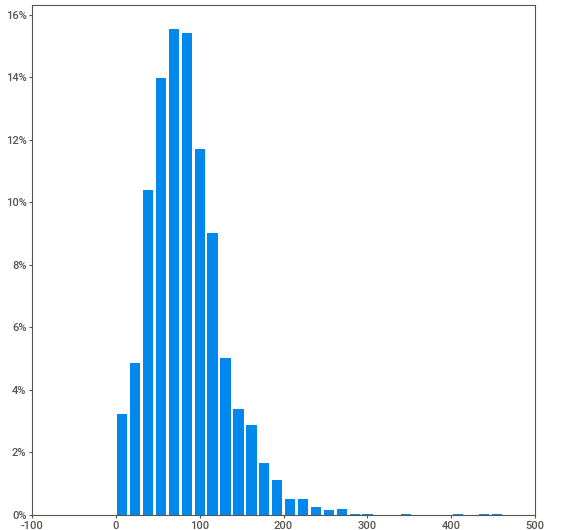
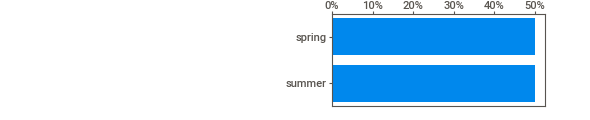
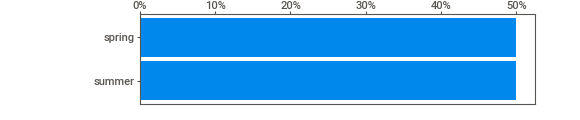
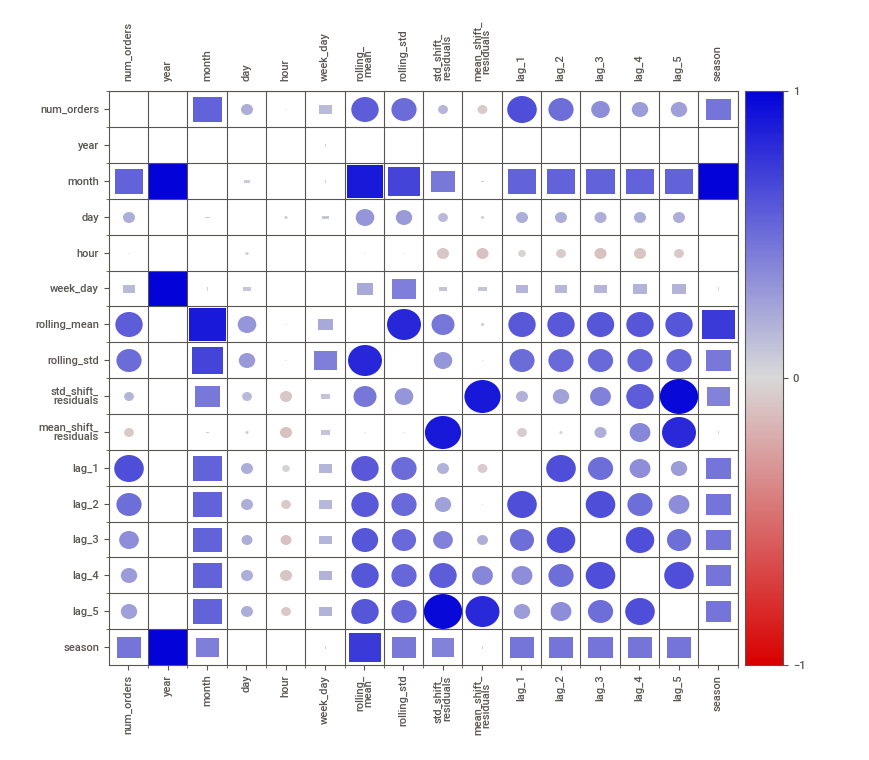
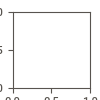

In [8]:
report = sv.analyze(data)
report.show_notebook()

**Из приведенного анализа видим, что признаки таблицы принимают нормальное распределение. Данные приведены только за 2018 год, он также является константным признаком, как и добавленные мной стандартное отклонение и среднее.**

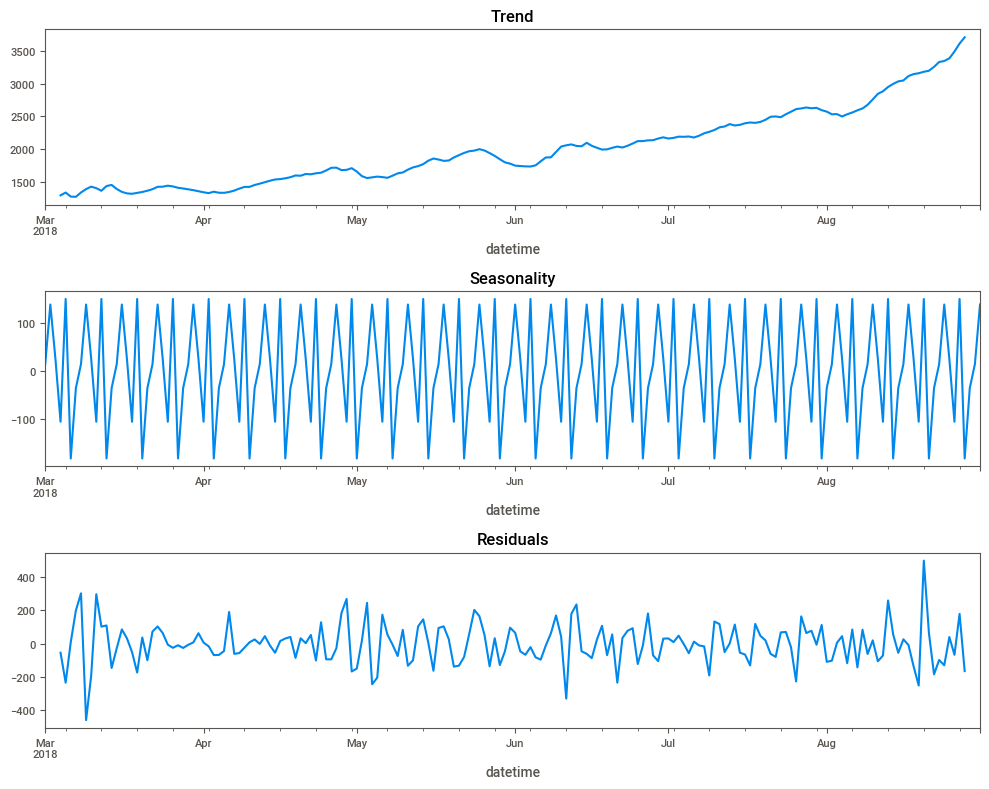

In [9]:
decomposed_data = data['num_orders'].copy()

decomposed_data = decomposed_data.resample('1d').sum()

decomposed = seasonal_decompose(decomposed_data)

plt.figure(figsize=(10,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

- График **Trend** сигнализирует нам, что за полугодовой промежуток, данный в исходной таблице, количество заказов с марта по конец августа все время растет.

- График **Seasonality** четко отображает, как минимума заказы достигают нв налаче недели, затем растут к середине, затем снова падают и достигают уже пика в выходные, что логично.

- График **Residuals** выглядит хаотично, без четкого возрастания/убывания, закономерности не прослеживаются. Это говорит о том, что модель композиции хорошо описала данные.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable year for analysis 1. Dropping this column
  warnings.warn(


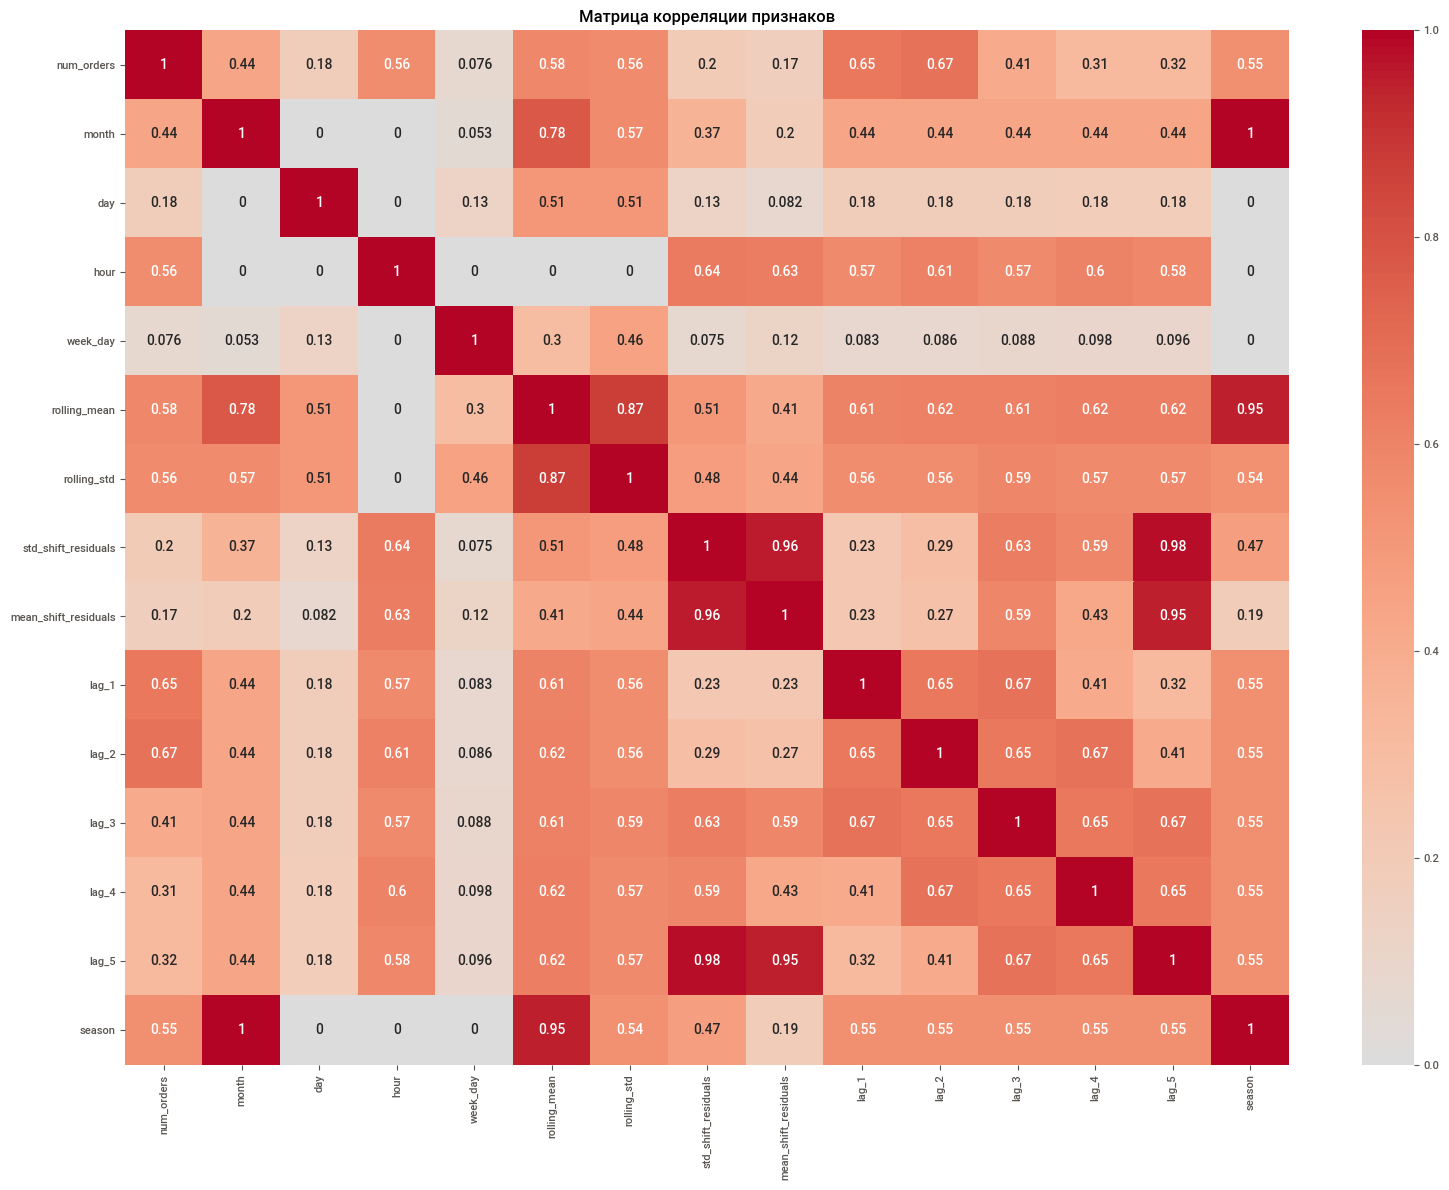

In [10]:
#Associations из Sweetviz недостаточно полноценно показывает корреляцию между всеми признаками, поэтому я взял phik

num_features = data.select_dtypes(include='number').columns.tolist()
corr = data.phik_matrix(interval_cols=num_features)

plt.figure(figsize=(16,12))
sns.heatmap(data=corr, cmap ='coolwarm', annot=True, center=0)
plt.title('Матрица корреляции признаков')
plt.tight_layout()
plt.show()

**Поскольку наши признаки являются искусственно созданными из нашего изначального, то мы наблюдаем их достаточно сильную сонаправленную взаимосвязь.**

- Сильнее всего зависимость между **num_orders** и **rolling_std** 0.69

- Следом 0.65-0.67 между **num_orders** c **Lag_1** и **Lag_2**.

- Хорошая зависимость между **num_orders** и **hour** 0.56.

- Далее 0.59 со **скользящей средней** и 0.55 с **сезоном (время года)**.

- Интересно, что система не видит зависимости с **week_day**, хотя ранее мы определили четкие закономерности снижения и увеличения суммы заказов в зависимости от дня недели. Думаю, что дело заключается в ресэмплировании по часам.

In [11]:
def scatter(feature_1,feature_2):
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=data,
                    x=feature_1, 
                    y=feature_2, 
                    palette = 'viridis', 
                    hue='num_orders',
                    s=30,
                    alpha=0.3)
    plt.title('Распределение признаков относительно num_orders')
    plt.xlabel(f'{feature_1}', fontsize=14)
    plt.ylabel(f'{feature_2}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

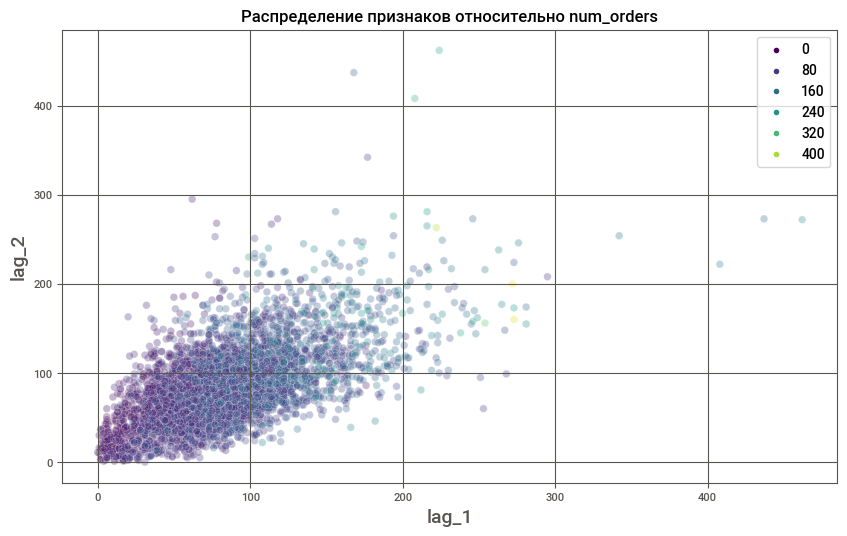

In [12]:
scatter('lag_1','lag_2')

**Прослеживается группировка основной массы значений от 0 до 120. Форма распределения стремится к линейной, но достаточно рассеянная.**

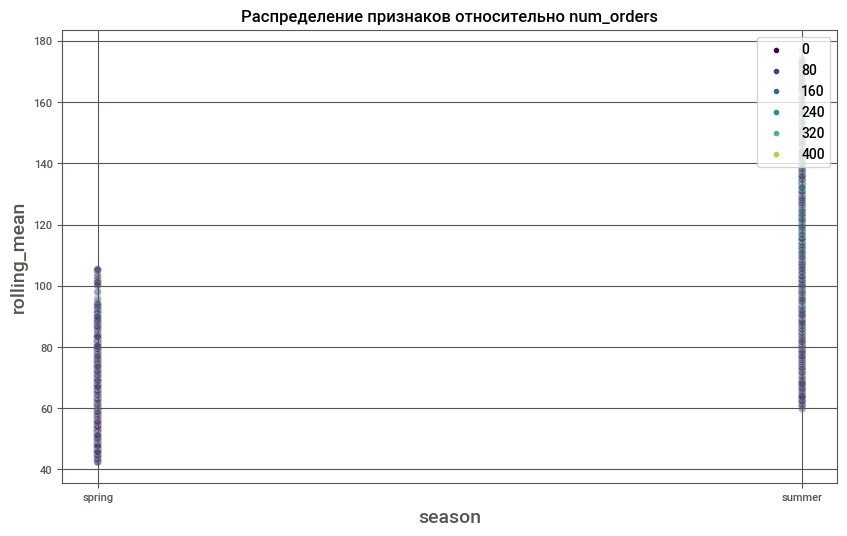

In [13]:
scatter('season', 'rolling_mean')

**Четко видим рост суммы заказов летом по сравнению с весной**

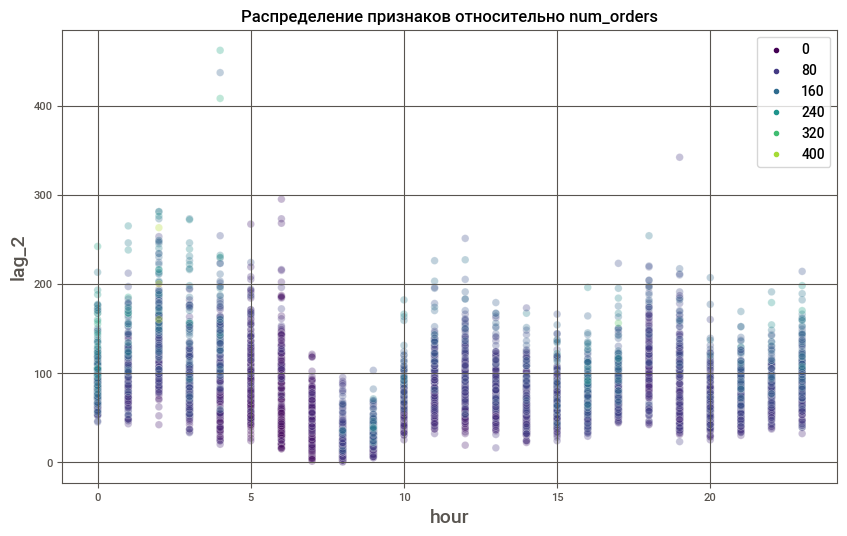

In [14]:
scatter('hour', 'lag_2')

**По часам наблюдаем абсолютно логичную картину:**

- Много заказов частов бывает в промежутке с 0 до 4 утра;

- Затем часто заказов становится больше с 12 до 13 - это традиционно обеденное время при офисной работе;

- Далее в районе 16-19 соответственно во время завершения рабочих часов;

- И с 21 до 24, когда люди едут на отдых/с отдыха

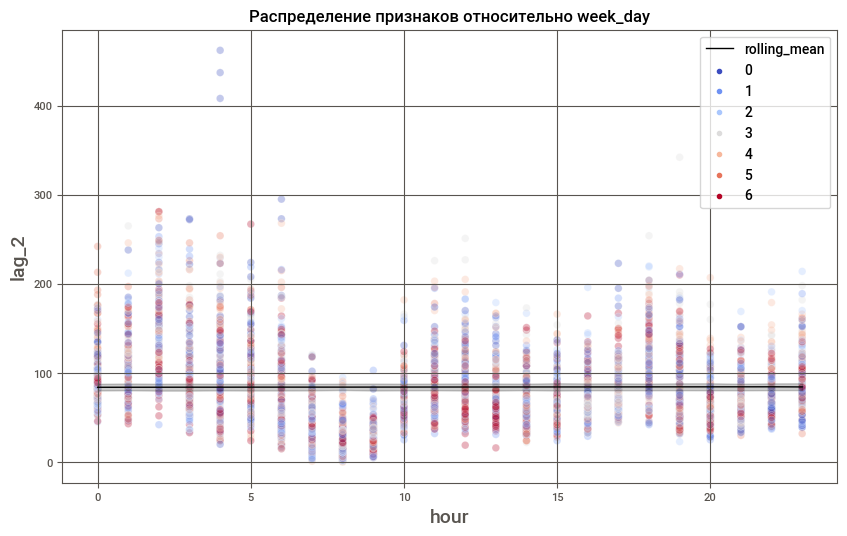

In [15]:
plt.figure(figsize=(10,6))

sns.scatterplot(data=data, 
                x='hour', 
                y='lag_2', 
                palette='coolwarm', 
                hue='week_day',
                s=30, alpha=0.3)

# Линия сгалживания
sns.lineplot(data=data, 
             x='hour', 
             y='rolling_mean', 
             color='black', 
             linewidth=1, 
             label='rolling_mean')

plt.title('Распределение признаков относительно week_day')
plt.xlabel('hour', fontsize=14)
plt.ylabel('lag_2', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


**Наконец, построив график распределения относительно week_day, мы можем увидеть, что пиков и минимумов как раз график распределения достигает в пятницы/субботы, а также во вторники**

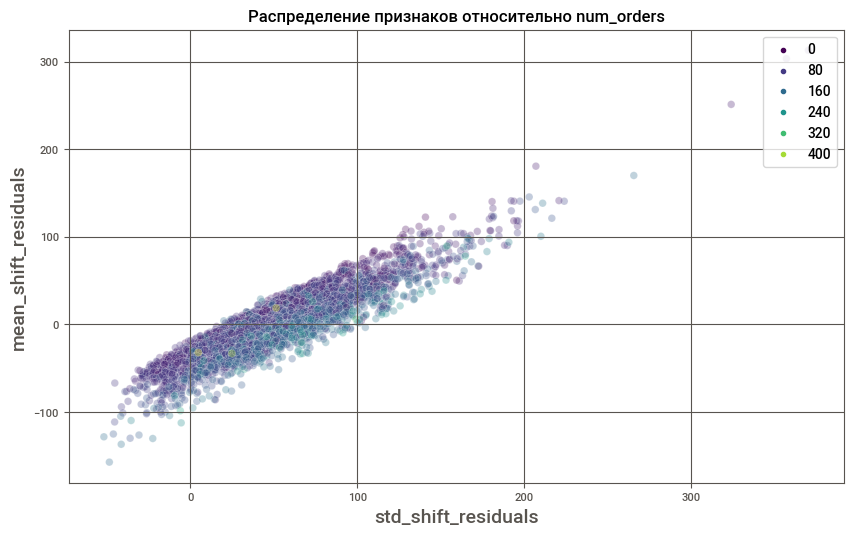

In [16]:
scatter('std_shift_residuals','mean_shift_residuals')

**Дополнительно проверил распределение остатков mean_shift_residuals и std_shift_residuals. График приобретает линейное очертание, но явно присутствует рассеянность, что не должно привести к переобучению модели**

### Вывод:

- Созданные признаки распределяются нормально, явных выбросов/аномалий не наблюдал;

- Наибольшее влияние на признак num_orders, исходя из аналзиа корреляции, rolling_std 0.69, 0.65-0.67 у Lag_1 и Lag_2, hour 0.56, 0.55 с season(время года), week_day также демонстрирует взаимосвязь с основным признаком при распределении по часам;

Больше всего заказов возникает 
- в дни: **вторник, среда, пятница, суббота**;
- в часы: **с 0 до 4, с 12 до 13, с 16 до 19, с 21 до 24**;
- исходя из предложенных данных: **больше заказов в летние месяцы, чем в весенние**.

## Обучение и тестирование

In [17]:
num_features = ['day', 'hour', 'week_day', 'rolling_std',
                'rolling_mean', 'std_shift_residuals', 'mean_shift_residuals', 
                'lag_1','lag_2', 'lag_3', 'lag_4', 'lag_5']
ohe_features = ['season']

features_data = data.drop(['year', 'month'],axis=1).dropna().copy()
X = features_data.drop('num_orders', axis=1).copy()
y = features_data['num_orders']

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=TEST_SIZE,
                                                 random_state=RANDOM_STATE)


<div class="alert alert-block alert-info">
<b>Совет:</b> пару строк про lag и скользящее среднее
    
Lag: его называют ещё параметром авторегрессии.<br>Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - влияют на сегодняшние.<br>Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br><br><br>
    
По скользящему среднего:<br>
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда. <br><br><br>
    
    
    
**Обычно так происходит поиск параметров:**

1) узнаём , какая у нас сезонность: в нашем случае их две - часовая и день недели (суточная и недельная)<br>
2) Узнайм, какой у нас тренд. пусть будет пока rolling (24) - сутки<br>
3) строим модель (без лагов).<br>
4) строим график автокорреляции остатков (факт - прогноз). Если видим "зубья" на сезонных лагах: 24, 24*7 - то мы плохо жанной моделью учли сезонность.<br>
Если высокий "зуб"(столбец на графике) на на первом лаге, то ндо вводить в модель фактор lag=1.
и перестроить модель. И так по кругу.<br><br>   
    
Поэтому, если выставить сезонности - час и день недели, то дополнительные факторы желательно начинать с таких значений : лаг =1,2 а скользящее среднее = 24 (среднее за сутки).  В итоге модель будет приемлемая по точности и не много факторов.. а это значит и для бизнеса будет легче доносить решение). Но, если нужно улучшить качество, то в нашем же случае лаг в 24 (день) и 168 (неделя) - тоже имеют смысл.
</div>



In [19]:
ohe_pipe = Pipeline([
    ('SimpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('Ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_features),
    ('num', StandardScaler(), num_features)
])

def optuna_body(trial):
    model_name = trial.suggest_categorical('model', ['LinearRegression', 'DecisionTree'])
    
    if model_name == 'LinearRegression':
        model = LinearRegression()
    else:
        model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        max_depth = trial.suggest_int('max_depth', 3,10)
        min_samples_split = trial.suggest_int('min_samples_split', 2,20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2,20)
        model.set_params(max_depth=max_depth,
                         min_samples_split=min_samples_split,
                         min_samples_leaf=min_samples_leaf)
        
    pipeline = Pipeline([('preprocessor', data_preprocessor),
                         ('model', model)])
    
    tscv = TimeSeriesSplit(n_splits=5)
    score = cross_val_score(pipeline, X_train,y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(optuna_body, n_trials=50)

print('Лучшая модель и ее параметры:', study.best_params)
print('Лучший показатель ошибки RMSE:', -study.best_value)

[I 2025-02-13 07:36:24,474] A new study created in memory with name: no-name-94a655a7-4ebc-425b-9fa7-73dcc7da4773
[I 2025-02-13 07:36:24,587] Trial 0 finished with value: -32.80660227819138 and parameters: {'model': 'DecisionTree', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 14}. Best is trial 0 with value: -32.80660227819138.
[I 2025-02-13 07:36:24,706] Trial 1 finished with value: -30.64861770062044 and parameters: {'model': 'DecisionTree', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 13}. Best is trial 1 with value: -30.64861770062044.
[I 2025-02-13 07:36:24,830] Trial 2 finished with value: -31.085574437658245 and parameters: {'model': 'DecisionTree', 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: -30.64861770062044.
[I 2025-02-13 07:36:25,074] Trial 3 finished with value: -33.11912686163415 and parameters: {'model': 'LinearRegression'}. Best is trial 1 with value: -30.64861770062044.
[I 2025-02-13 07:36:

Лучшая модель и ее параметры: {'model': 'DecisionTree', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 18}
Лучший показатель ошибки RMSE: 29.90405145738124


**Лучшей моделью из простых на тренировочной выборке стала DecisionTreeRegressor с параметрами (max_depth= 10, min_samples_split= 18, min_samples_leaf= 18), которая показала метрику ошибок RMSE = 29.81**

In [20]:
base_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(max_depth= 8, 
                                        min_samples_split= 4, 
                                        min_samples_leaf= 5,
                                        random_state=RANDOM_STATE))
])

base_pipeline.fit(X_train,y_train)
preds = base_pipeline.predict(X_test)
rmse_tree_test = mean_squared_error(y_test, preds, squared=False)

print(f'RMSE на тестовой выборке DecisionTreeRegressor: {rmse_tree_test:.4f}')

RMSE на тестовой выборке DecisionTreeRegressor: 29.9683


In [21]:
boost_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(objective='regression', metric='rmse'))
])

boost_pipeline.fit(X_train, y_train)
boost_train_preds = boost_pipeline.predict(X_train)
rmse_train = mean_squared_error(y_train, boost_train_preds, squared=False)
boost_test_preds = boost_pipeline.predict(X_test)
rmse_test = mean_squared_error(y_test, boost_test_preds, squared=False)

print(f'RMSE на тренировочной выборке LGBMRegressor: {rmse_train:.4f}')
print(f'RMSE на тестовой выборке LGBMRegressor: {rmse_test:.4f}')

RMSE на тренировочной выборке LGBMRegressor: 15.3484
RMSE на тестовой выборке LGBMRegressor: 24.7530


**Поскольку в тз не было написано сколько моделей я могу проверять на тестовых данных, я также решил применить метод градиентного бустинга**

По результатам метрики RMSE на тестовой выборке лучшей моделью стала LGBMRegressor с результатом 24.75, что более чем отвечает техническому заданию.

### Вывод:

Лучшей моделью с точки зрения показателя метрики RMSE стала **LGBMRegressor**

## Анализ модели

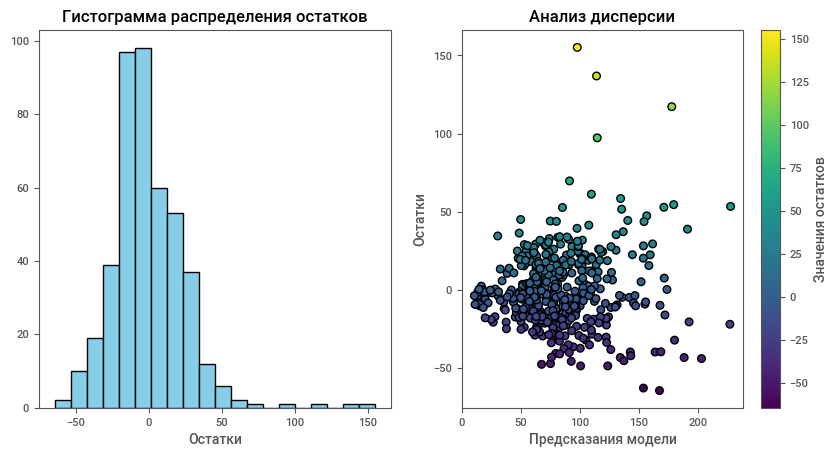

In [22]:
predictions = boost_test_preds
residuals = y_test - boost_test_preds


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals, bins=20, color='skyblue', ec='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
scatter = axes[1].scatter(x=predictions, y=residuals, c=residuals, cmap='viridis', edgecolor='k', s=30)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
cbar = fig.colorbar(scatter, ax=axes[1])
cbar.set_label('Значения остатков')

**Распределение остатков модели является нормальным, есть совсем незначительные выбросы в районе значения 150. Модель хорошо предсказывает значения от 0 до 120, но на более высоких может достаточно сильно ошибиться. В любом случае, само понятие высокого спроса она предсказывает хорошо**

**Перейдем к анализу работы модели. Поскольку DecisionTree - частный случай модели LGBMRegressor. Анализ важности признаков я также продемонстрирую на ней**

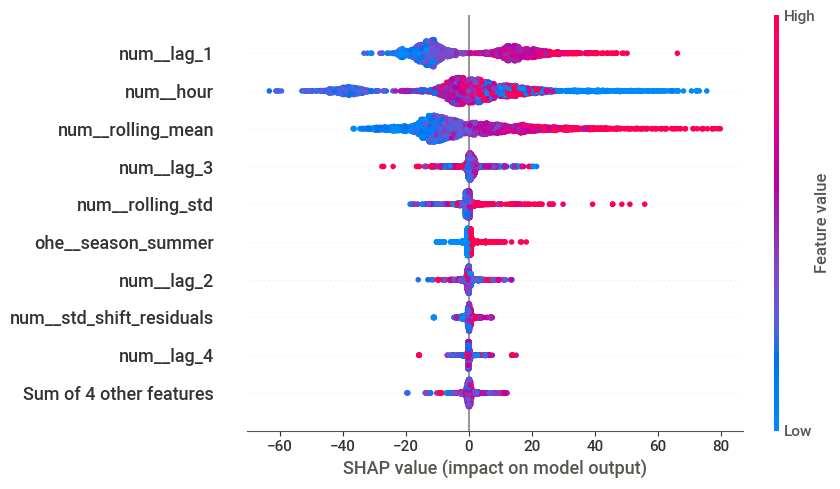

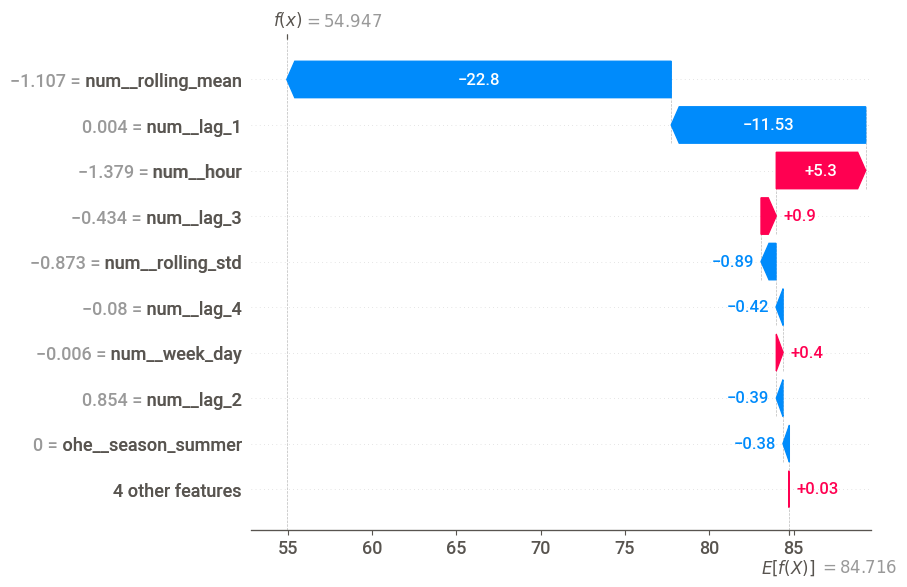

In [23]:
analize_model = base_pipeline.named_steps['models']
X_train_preprocessed = data_preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,
                       columns = data_preprocessor.get_feature_names_out())

explainer = shap.TreeExplainer(analize_model)
shap_values = explainer.shap_values(X_train_preprocessed)
shap_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train_preprocessed)

shap.plots.beeswarm(shap_exp)
shap.plots.waterfall(shap_exp[0])

*Наиболее важными для модели являются признаки:*
- lag_1
- hour
- month
- rolling_std
- day
- rolling_mean

*На втором графике мы четко видим, как значение месяца, lag_1 и rolling_std увеличивают значение предсказания, а day наоборот занижает*

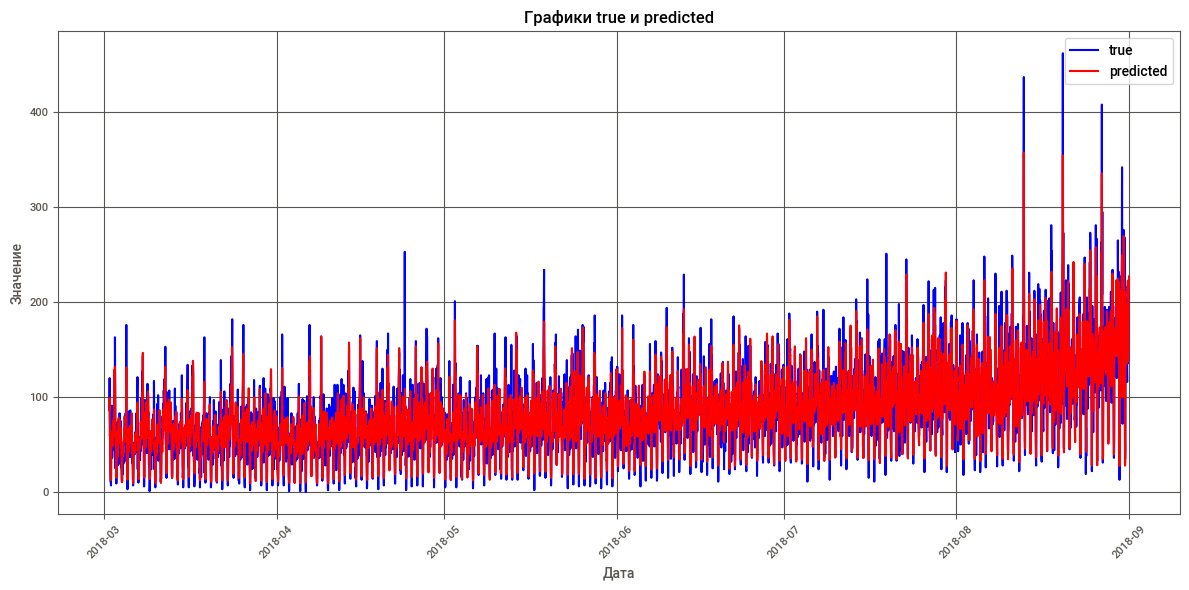

In [35]:
def results(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['true'], label='true', color="blue")
    plt.plot(df.index, df['predicted'], label='predicted', color="red")
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.title('Графики true и predicted')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.show()
    
moon = features_data.dropna().copy()
main = moon.drop('num_orders', axis=1).copy()
true = moon['num_orders'].copy()

body = boost_pipeline.predict(main)

collab = pd.DataFrame({'true':true, 'predicted':body})

results(collab)

**По часам график читать трудновато, попробуем выставить изучить интервал за 1 месяц.**

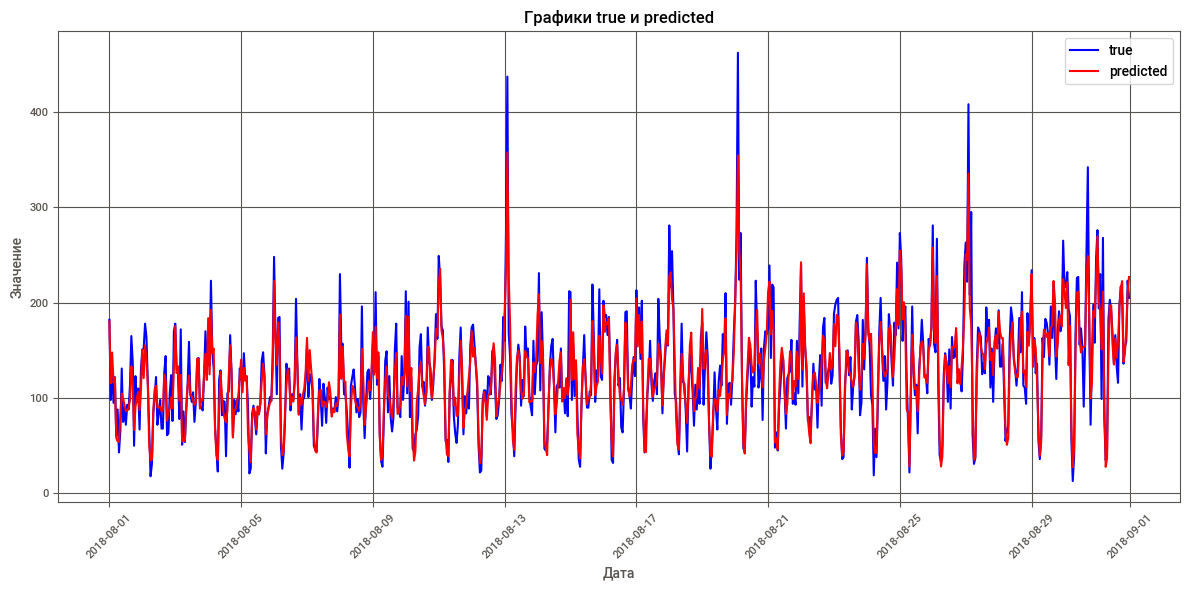

In [37]:
collab_interval=collab['2018-08':'2018-09'].copy()
results(collab_interval)

**Модель хорошо прогнозирует поведение признака num_orders, но самые высокие значения недооценивает. Посмотрим, в какие дни недели у модели могут быть проблемы**

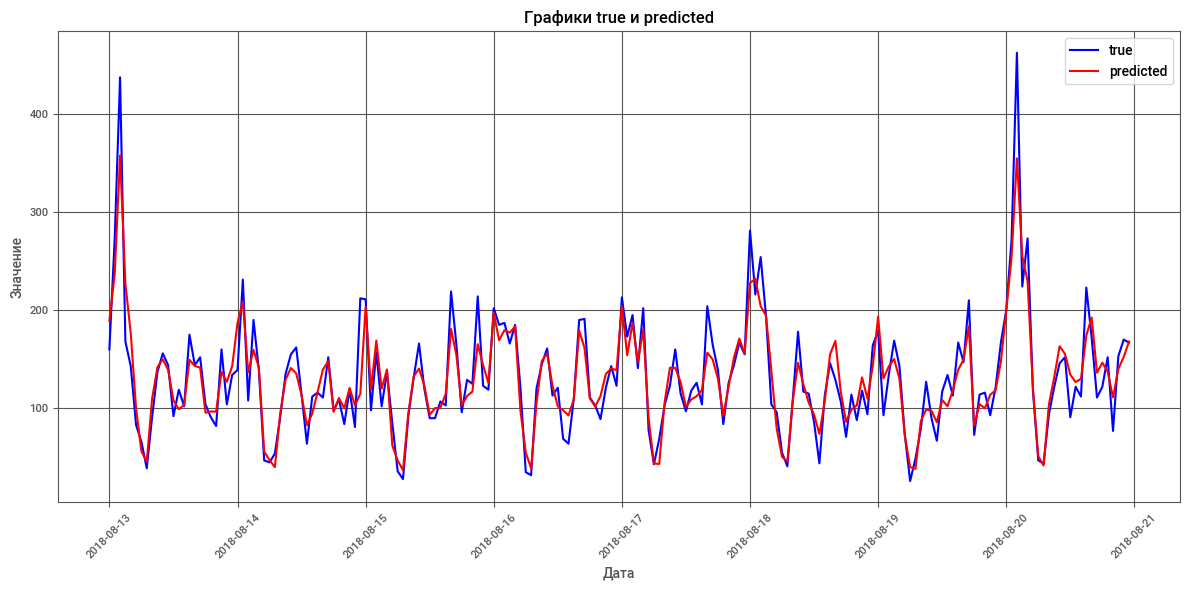

In [39]:
collab_interval_week=collab['2018-08-13':'2018-08-20'].copy()
results(collab_interval_week)

**Модель предсказывает высокий спрос, но с точностью количества заказа ошибается в дни наибольшей загруженности. Здесь это понедельник и суббота.**

### Вывод
- Топ 5 признаков для предсказания num_orders: **lag_1, hour, month, rolling_std, day, rolling_mean**;
- Если брать в расчет также и скорость работы модели, то стоит сделать выбор в пользу простой модели DecisionTreeRegressor.
- Модель отлично предсказывает дни обычного спроса на такси, а дни высокого спроса предсказывает с небольшой недооценкой целевого признака.

## Заключение

Задачей данного проекта являлась разработка модели для предсказания пиковой нагрузки сервиса компании «Чётенькое такси». Важным критерием технического задания был результат метрики RMSE не больше 48

С точки зрения поставленной заказчиком задачи лучше всего справилась модель **LGBMRegressor с RMSE=24,75**. С другой стороны, если для заказчика все же значима скорость обработки и выдачи результата, то я бы рекомендовал простую модель **DecisionTreeRegressor с параметрами (max_depth=10, min_samples_split=18, min_samples_leaf=18) c RMSE=29,97**. Метрика ошибок также хороша, но и скорость работы значительно быстрее**

**Портрет пиковых интервалов работы сервиса:**
- дни: вторник, среда, пятница, суббота;
- часы: с 0 до 4, с 12 до 13, с 16 до 19, с 21 до 24;
- исходя из предложенных данных с марта по август: больше заказов в летние месяцы, чем в весенние.

*Для поиска лучшей базовой модели был выбран метод OptunaSearchCV, поскольку позволяет рассмотреть большое количество комбинаций в короткий срок и дать точные результаты.*

*Во время проекта были подготовлены новые признаки, проведен их ислледовательский и корреляционный анализы*